In [1]:
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import warnings
import pandana as pdna
import os

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Load data
filepath = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Montereale_Valcellina_lts.graphml"
G_lts = ox.load_graphml(filepath)
G_lts = ox.projection.project_graph(G_lts, to_crs='32632')
#crs = G_lts.graph['crs']

base_path = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/images"
city_name = "Montereale_Valcellina"

# Create the path for the new folder
city_folder_path = os.path.join(base_path, city_name)

# Create the folder if it doesn't exist
if not os.path.exists(city_folder_path):
    os.makedirs(city_folder_path)

Nodes with highest degree centrality: [(4187438672, 8), (912298892, 8), (912287486, 8), (3783691645, 8), (318694398, 8)]
Nodes with highest closeness centrality: [(912287486, 0.000192), (912311207, 0.000192), (2143843981, 0.000192), (2078574783, 0.000192), (912298004, 0.000192)]
Nodes with highest betweenness centrality: [(912287486, 0.103586), (375694255, 0.101358), (912306334, 0.09987), (1875944482, 0.098084), (318694350, 0.097929)]
2135
[(375694438, 4230598315, 0), (375694438, 375694362, 0), (375694438, 375694984, 0), (4230598315, 375694438, 0), (4230598315, 4537840691, 0)]
Edges with highest edge betweenness centrality: [((912305827, 665371479), 0.056082), ((665371479, 5774515722), 0.05544), ((665371476, 912305827), 0.055301), ((5774515722, 1875944482), 0.055214), ((1875944482, 2142859863), 0.053028)]
Number of Strongly Connected Components: 328


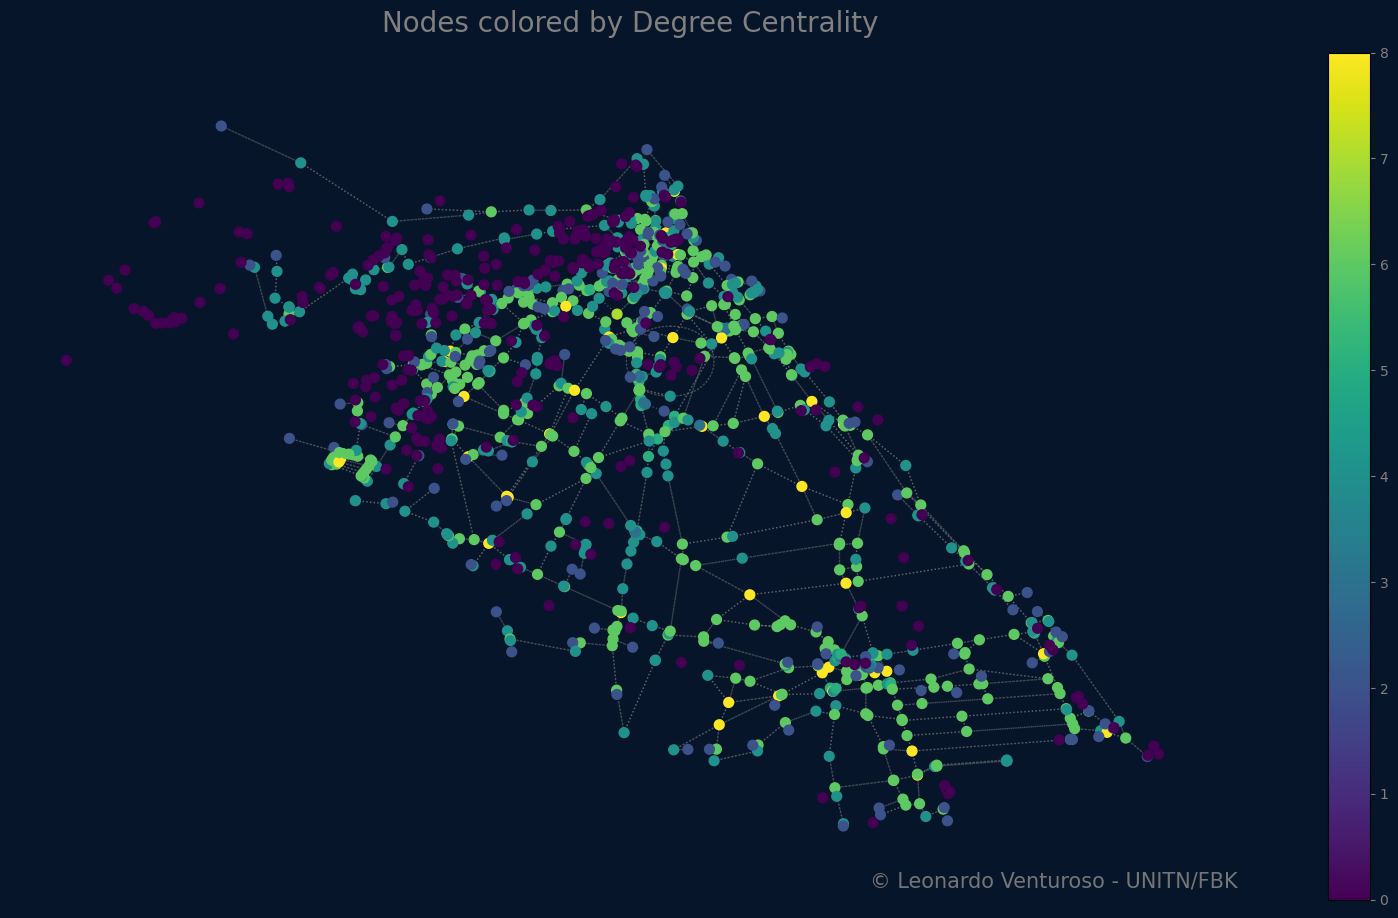

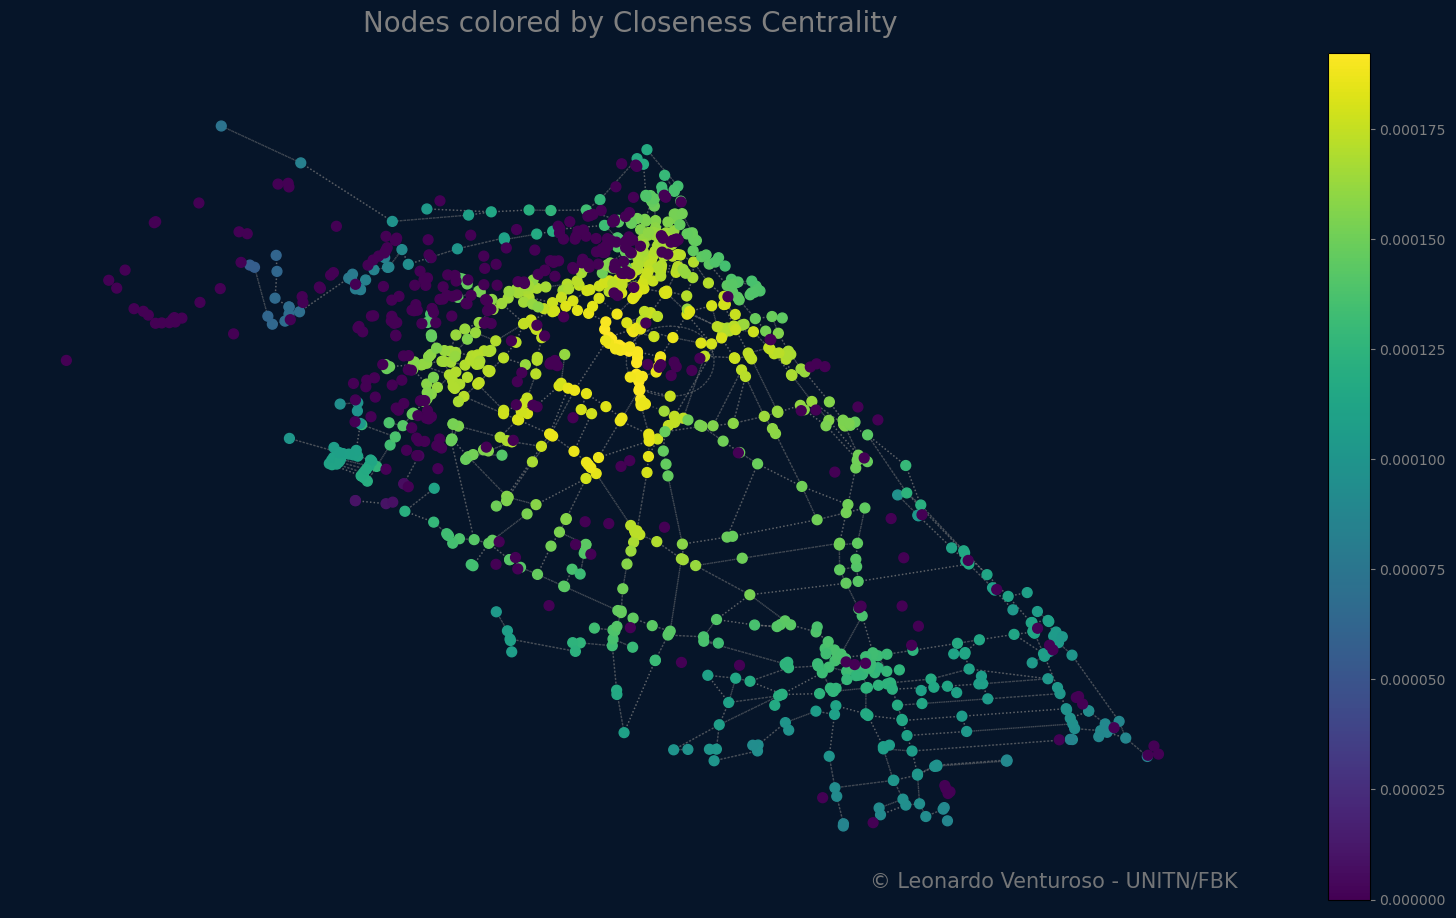

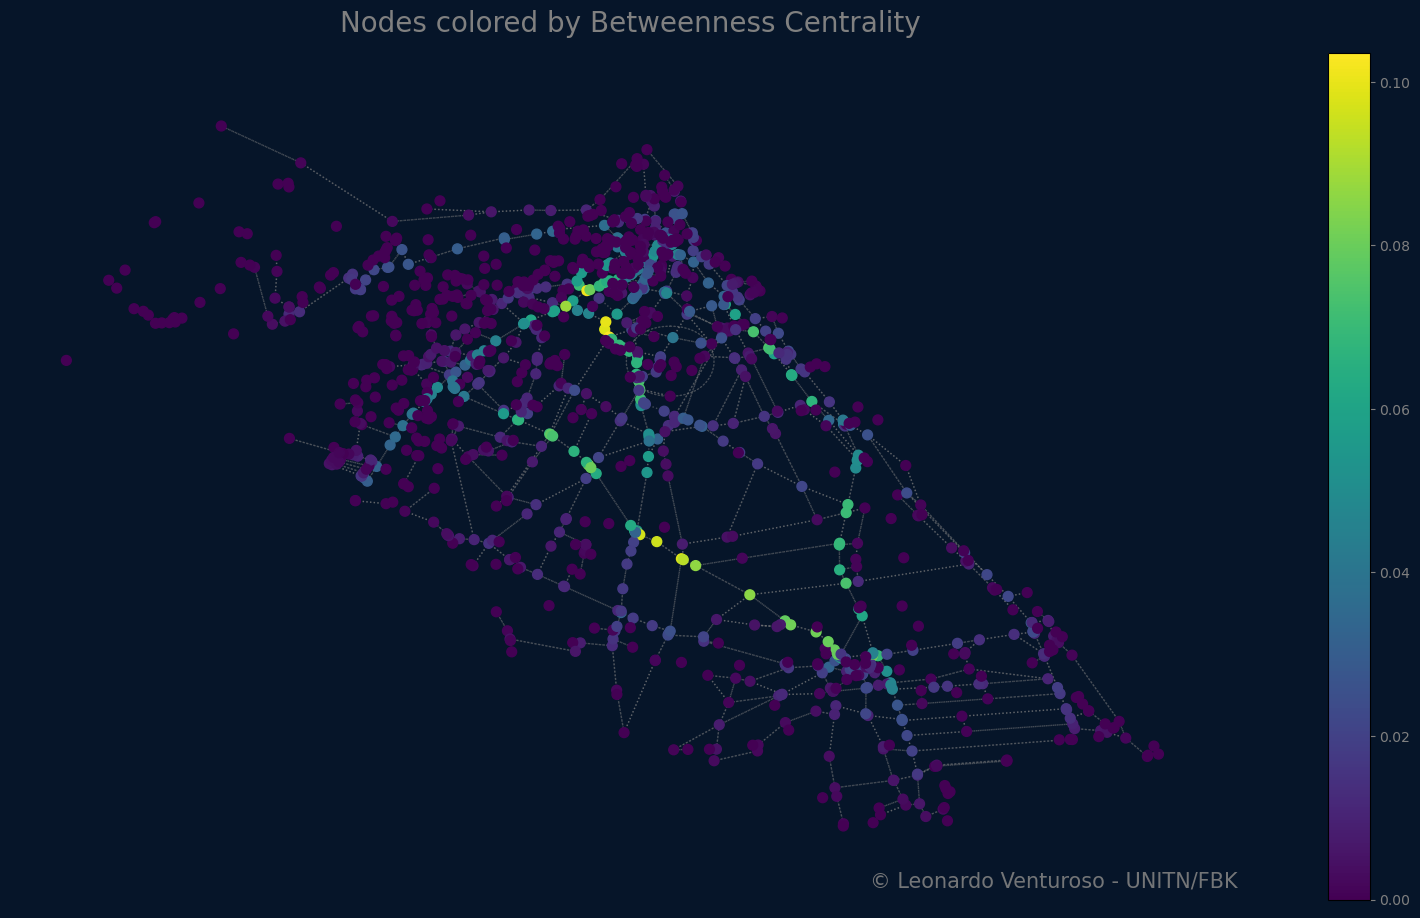

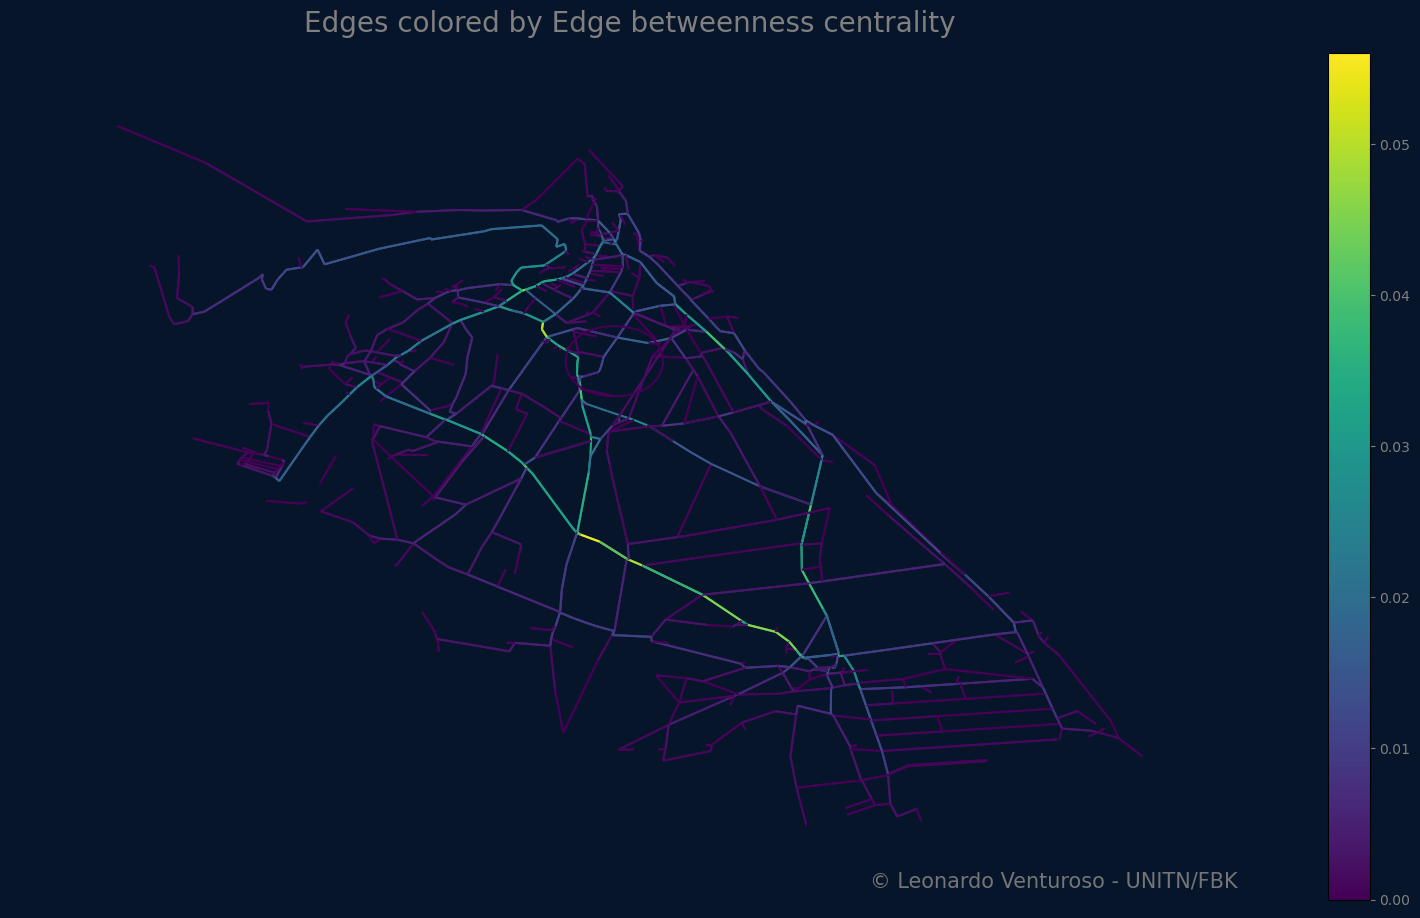

In [8]:
# Network Analysis - Centrality

def degree_centrality(G):
    """Calculate degree centrality."""
    return {node: G.degree(node) for node, data in G.nodes(data=True)}

def closeness_centrality(G):
    """Calculate closeness centrality."""
    return nx.closeness_centrality(G, distance='length')

def betweenness_centrality(G):
    """Calculate betweenness centrality."""
    return nx.betweenness_centrality(G, weight='length')

# Calculate degree centrality
degree_centrality_values = degree_centrality(G_lts)

# Nodes with highest degree centrality (top 5)
top_degree_nodes = sorted(degree_centrality_values.items(), key=lambda x: x[1], reverse=True)[:5]

# Closeness Centrality
closeness_centrality_values = closeness_centrality(G_lts)
top_closeness_nodes = sorted(closeness_centrality_values.items(), key=lambda x: x[1], reverse=True)[:5]
# Round the values of the second term
top_closeness_nodes_rounded = [(node, round(value, 6)) for node, value in top_closeness_nodes]

# Betweenness Centrality
betweenness_centrality_values = betweenness_centrality(G_lts)
top_betweenness_nodes = sorted(betweenness_centrality_values.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness_nodes_rounded = [(node, round(value, 6)) for node, value in top_betweenness_nodes]

print("Nodes with highest degree centrality:", top_degree_nodes)
print("Nodes with highest closeness centrality:", top_closeness_nodes_rounded)
print("Nodes with highest betweenness centrality:", top_betweenness_nodes_rounded)

def edge_betweenness_centrality(G):
    """Calculate edge betweenness centrality."""
    return nx.edge_betweenness_centrality(G, weight='length')

# Edge Betweenness Centrality
edge_betweenness_centrality_values = edge_betweenness_centrality(G_lts)
print(len(edge_betweenness_centrality_values))
print(list(edge_betweenness_centrality_values.keys())[:5])
top_edge_betweenness = sorted(edge_betweenness_centrality_values.items(), key=lambda x: x[1], reverse=True)[:5]
top_edge_betweenness_rounded = [((u, v), round(value, 6)) for (u, v, *_) , value in top_edge_betweenness]

print("Edges with highest edge betweenness centrality:", top_edge_betweenness_rounded)

# Identify strongly connected components - SCCs
sccs = list(nx.strongly_connected_components(G_lts))
print(f"Number of Strongly Connected Components: {len(sccs)}")

def draw_graph(G, centrality_values, title, filepath):
    # Filter out nodes that don't have centrality values
    nodes_to_include = [node for node in G.nodes() if node in centrality_values]
    subgraph = G.subgraph(nodes_to_include)
    
    # Use geographical coordinates for positioning
    pos = {node: (data['x'], data['y']) for node, data in subgraph.nodes(data=True)}
    
    node_colors = [centrality_values[node] for node in subgraph.nodes()]
    
    # Figure setup
    fig, ax = plt.subplots(figsize=(20,11))
    ax.set_facecolor("#061529")
    fig.set_facecolor("#061529")
    
    # Color scale
    cmap = plt.cm.viridis
    vmin = min(node_colors)
    vmax = max(node_colors)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = plt.colorbar(sm)
    cbar.ax.yaxis.set_tick_params(color='grey')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='grey')
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G=subgraph, pos=pos, node_color=node_colors, cmap=cmap, alpha=1, node_size=50)
    nx.draw_networkx_edges(G=subgraph, pos=pos, edge_color='grey', style="dotted", alpha=0.5, arrows=False)
    
    # Labeling Axes
    ax.set_title(title, fontdict={"fontsize":20, "color": "grey"}, pad=15)
    ax.axis('off')
    

    # Watermark
    ax.text(0.99, 0.01, '© Leonardo Venturoso - UNITN/FBK',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)
    
    plt.savefig(filepath, bbox_inches='tight', dpi=300)
    
    plt.show()

image_file_path_1 = os.path.join(city_folder_path, "nodes_degree_centrality.png")
## Visualize nodes based on Degree Centrality
draw_graph(G_lts, degree_centrality_values, 'Nodes colored by Degree Centrality', image_file_path_1)

image_file_path_2 = os.path.join(city_folder_path, "nodes_closeness_centrality.png")
## Visualize nodes based on Closeness Centrality
draw_graph(G_lts, closeness_centrality_values, 'Nodes colored by Closeness Centrality', image_file_path_2)

image_file_path_3 = os.path.join(city_folder_path, "nodes_betweenness_centrality.png")
## Visualize nodes based on Betweenness Centrality
draw_graph(G_lts, betweenness_centrality_values, 'Nodes colored by Betweenness Centrality', image_file_path_3 )


def draw_edges(G, centrality_values, title, filepath):
    # 1. Identify common edges between G and centrality_values
    common_edges = set(G.edges()).intersection(set(centrality_values.keys()))
    
    # 2. Construct the edge colors by accommodating both edge orientations
    edge_colors = [centrality_values[edge] if edge in centrality_values else centrality_values[(edge[1], edge[0])] for edge in common_edges]
    
    # Use geographical coordinates for positioning
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    
    # Figure setup
    fig, ax = plt.subplots(figsize=(20, 11))
    ax.set_facecolor("#061529")
    fig.set_facecolor("#061529")
    
    # Color scale
    cmap = plt.cm.viridis
    vmin = min(edge_colors)
    vmax = max(edge_colors)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = plt.colorbar(sm)
    cbar.ax.yaxis.set_tick_params(color='grey')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='grey')
    
    # Draw edges with their centrality values
    nx.draw_networkx_edges(G, pos, edgelist=common_edges, edge_color=edge_colors, edge_cmap=cmap, alpha=1, width=1.5, arrows=False)
    
    # Labeling Axes
    ax.set_title(title, fontdict={"fontsize": 20, "color": "grey"}, pad=15)
    ax.axis('off')
    
    # Watermark
    ax.text(0.99, 0.01, '© Leonardo Venturoso - UNITN/FBK',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)
    plt.savefig(filepath, bbox_inches='tight', dpi=300)

    plt.show()

# Call the function to visualize
fixed_edge_betweenness = {(u, v): value for (u, v, *_), value in edge_betweenness_centrality_values.items()}
image_file_path_4 = os.path.join(city_folder_path, "edge_betweenness_centrality.png")
draw_edges(G_lts, fixed_edge_betweenness, "Edges colored by Edge betweenness centrality", image_file_path_4)



High-stress nodes: [912306659, 912298106, 9407403115, 3445307007, 912292632, 4417658388, 375694262, 275047641, 6532857567, 912303265, 912298815, 6532722874, 275047646, 1812883495, 3493141395, 1812883498, 912285250, 275047789, 1812888011, 3741329882, 3741329912, 295257285, 275047807, 912298224, 912293688, 912302747, 778888939, 912305093, 275048618, 1902148479, 1902148592, 912298892, 912294208, 912295544, 275048626, 912285611, 912296850, 912305987, 3710631528, 2465682443, 275052691, 3471819403, 2208780228, 912283507, 6514628942, 4109186227, 295279410, 912294506, 2142860777, 912282927, 318694369, 3481947933, 1865801228, 912298234, 912295039, 318694398, 912282520, 912298174, 912289270, 4007156374, 318694413, 912302147, 912296263, 1865801254, 326044370, 326044388, 1711192659, 326044650, 3137433200, 3647507513, 375693963, 912302191, 912311114, 912283315, 1812883484, 912304459, 11020585071, 375694255, 492115024, 912307782, 1812883474, 912303842, 6684822552, 912312119, 402579041, 402579695, 40

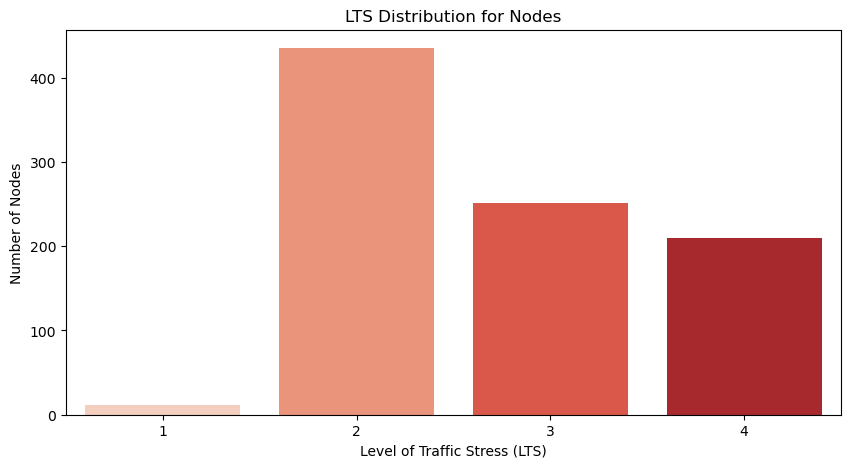

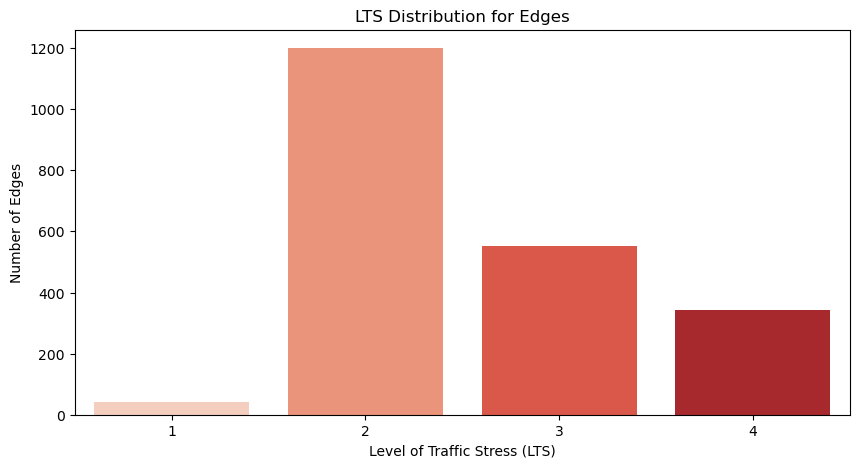

Nodes - Mean LTS: 2.73, Median LTS: 3.0, Standard Deviation: 0.83
Edges - Mean LTS: 2.56, Median LTS: 2.0, Standard Deviation: 0.78


In [9]:
# Geospatial Analysis

import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Identify nodes (intersections) with the highest LTS.

## Nodes with highest LTS
high_stress_nodes = [node for node, data in G_lts.nodes(data=True) if 'lts' in data and data['lts'] == '4']

## Identify roads (edges) with the highest LTS.
high_stress_edges = [(u, v) for u, v, data in G_lts.edges(data=True) if 'lts' in data and data['lts'] == '4']

print(f"High-stress nodes: {high_stress_nodes}")
print(f"High-stress edges: {high_stress_edges}")
print(f"Number of high-stress nodes: {len(high_stress_nodes)}")
print(f"Number of high-stress edges: {len(high_stress_edges)}")

## Calculate the average LTS for the entire network.

## Convert LTS values to integers for calculation, ensuring the 'lts' attribute exists
lts_values_nodes = [int(data['lts']) for _, data in G_lts.nodes(data=True) if 'lts' in data]
lts_values_edges = [int(data['lts']) for _, _, data in G_lts.edges(data=True) if 'lts' in data]

## Distribution of the Level of Traffic Stress (LTS) among nodes and edges.
from collections import Counter

## Count the frequency of each LTS value for nodes and edges
lts_node_freq = Counter(lts_values_nodes)
lts_edge_freq = Counter(lts_values_edges)

## Order the Counter objects by their keys
lts_node_freq = dict(sorted(lts_node_freq.items()))
lts_edge_freq = dict(sorted(lts_edge_freq.items()))

print("Ordered LTS distribution for nodes:", lts_node_freq)
print("Ordered LTS distribution for edges:", lts_edge_freq)

## Plot for nodes
plt.figure(figsize=(10, 5))
sns.countplot(lts_values_nodes, palette="Reds", order=sorted(set(lts_values_nodes)))
plt.xlabel('Level of Traffic Stress (LTS)')
plt.ylabel('Number of Nodes')
plt.title('LTS Distribution for Nodes')
file_path = os.path.join(city_folder_path, 'lts_distrib_nodes_plot.png')
plt.savefig(file_path)
plt.show()

## Plot for edges
plt.figure(figsize=(10, 5))
sns.countplot(lts_values_edges, palette="Reds", order=sorted(set(lts_values_edges)))
plt.xlabel('Level of Traffic Stress (LTS)')
plt.ylabel('Number of Edges')
plt.title('LTS Distribution for Edges')
file_path = os.path.join(city_folder_path, 'lts_distrib_edges_plot.png')
plt.savefig(file_path)
plt.show()

## Descriptive Statistic about LTS - Nodes & Edges
mean_lts_nodes = np.mean(lts_values_nodes)
median_lts_nodes = np.median(lts_values_nodes)
std_dev_lts_nodes = np.std(lts_values_nodes)

mean_lts_edges = np.mean(lts_values_edges)
median_lts_edges = np.median(lts_values_edges)
std_dev_lts_edges = np.std(lts_values_edges)

print(f"Nodes - Mean LTS: {round(mean_lts_nodes,2)}, Median LTS: {round(median_lts_nodes,2)}, Standard Deviation: {round(std_dev_lts_nodes,2)}")
print(f"Edges - Mean LTS: {round(mean_lts_edges,2)}, Median LTS: {round(median_lts_edges,2)}, Standard Deviation: {round(std_dev_lts_edges,2)}")


In [12]:
# Network Analysis

## Calculate centrality measures to identify important nodes (intersections) in the network.

def lts_weighted_degree_centrality(G):
    """Calculate degree centrality weighted by LTS."""
    return {node: G.degree(node) * int(data['lts']) for node, data in G.nodes(data=True) if 'lts' in data}

def lts_weighted_closeness_centrality(G):
    """Calculate closeness centrality weighted by LTS."""
    for u, v, data in G.edges(data=True):
        data['lts_weight'] = data['length'] / int(data['lts'])
    return nx.closeness_centrality(G, distance='lts_weight')

def lts_weighted_betweenness_centrality(G):
    """Calculate betweenness centrality weighted by LTS."""
    for u, v, data in G.edges(data=True):
        data['lts_weight'] = data['length'] / int(data['lts'])
    return nx.betweenness_centrality(G, weight='lts_weight')


## Calculate degree centrality
degree_centrality = lts_weighted_degree_centrality(G_lts)

## Nodes with highest degree centrality (top 5)
top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

## Closeness Centrality
closeness_centrality = lts_weighted_closeness_centrality(G_lts)
top_closeness_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
# Round the values of the second term
top_closeness_nodes_rounded = [(node, round(value, 6)) for node, value in top_closeness_nodes]

## Betweenness Centrality
betweenness_centrality = lts_weighted_betweenness_centrality(G_lts)
top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness_nodes_rounded = [(node, round(value, 6)) for node, value in top_betweenness_nodes]

print("Nodes with highest degree centrality:", top_degree_nodes)
print("Nodes with highest closeness centrality:", top_closeness_nodes_rounded)
print("Nodes with highest betweenness centrality:", top_betweenness_nodes_rounded)

## Centrality measures for important edges:
def lts_weighted_edge_betweenness_centrality(G):
    """Calculate edge betweenness centrality weighted by LTS."""
    # Update the graph with the new weighted lengths
    for u, v, data in G.edges(data=True):
        data['lts_weight'] = data['length'] / int(data['lts'])
    return nx.edge_betweenness_centrality(G, weight='lts_weight')

## Edge Betweenness Centrality
edge_betweenness_centrality = lts_weighted_edge_betweenness_centrality(G_lts)
top_edge_betweenness = sorted(edge_betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_edge_betweenness_rounded = [((u, v), round(value, 6)) for (u, v, *_) , value in top_edge_betweenness]

print("Edges with highest betweenness centrality:", top_edge_betweenness_rounded)

## Identify strongly connected components - SCCs, since graph is directed. A strongly connected component of a directed graph 
## is a maximal strongly connected subgraph.That is, it's a subgraph where every vertex is reachable from every other vertex in the subgraph.

sccs = list(nx.strongly_connected_components(G_lts))
print(f"Number of Strongly Connected Components: {len(sccs)}")

## High-Stress Subgraphs: Identify subgraphs (connected components) of the network that have a high average LTS (LTS = 4). 
## This can help in pinpointing areas that are particularly stressful for cyclists or pedestrians.

# First, create a subgraph with only edges having LTS = 4
high_stress_edges = [(u, v, k) for u, v, k, d in G_lts.edges(keys=True, data=True) if 'lts' in d and d.get('lts') == '4']
G_high_stress = G_lts.edge_subgraph(high_stress_edges)

# Then, identify the connected components of this subgraph
high_stress_subgraphs = list(nx.strongly_connected_components(G_high_stress))
print(f"Number of High-Stress Subgraphs: {len(high_stress_subgraphs)}")


Nodes with highest degree centrality: [(912298892, 32), (318694398, 32), (912296263, 32), (375693963, 32), (912303842, 32)]
Nodes with highest closeness centrality: [(2980754259, 0.000549), (295279410, 0.000549), (912306120, 0.000549), (912289180, 0.000548), (2980754256, 0.000548)]
Nodes with highest betweenness centrality: [(2142859863, 0.150788), (665371479, 0.150602), (5774515722, 0.149674), (1875944482, 0.149368), (665371590, 0.14606)]
Edges with highest betweenness centrality: [((912305827, 665371479), 0.0778), ((665371479, 5774515722), 0.077129), ((5774515722, 1875944482), 0.076873), ((1875944482, 2142859863), 0.076761), ((2142859863, 665371590), 0.074328)]
Number of Strongly Connected Components: 328
Number of High-Stress Subgraphs: 42


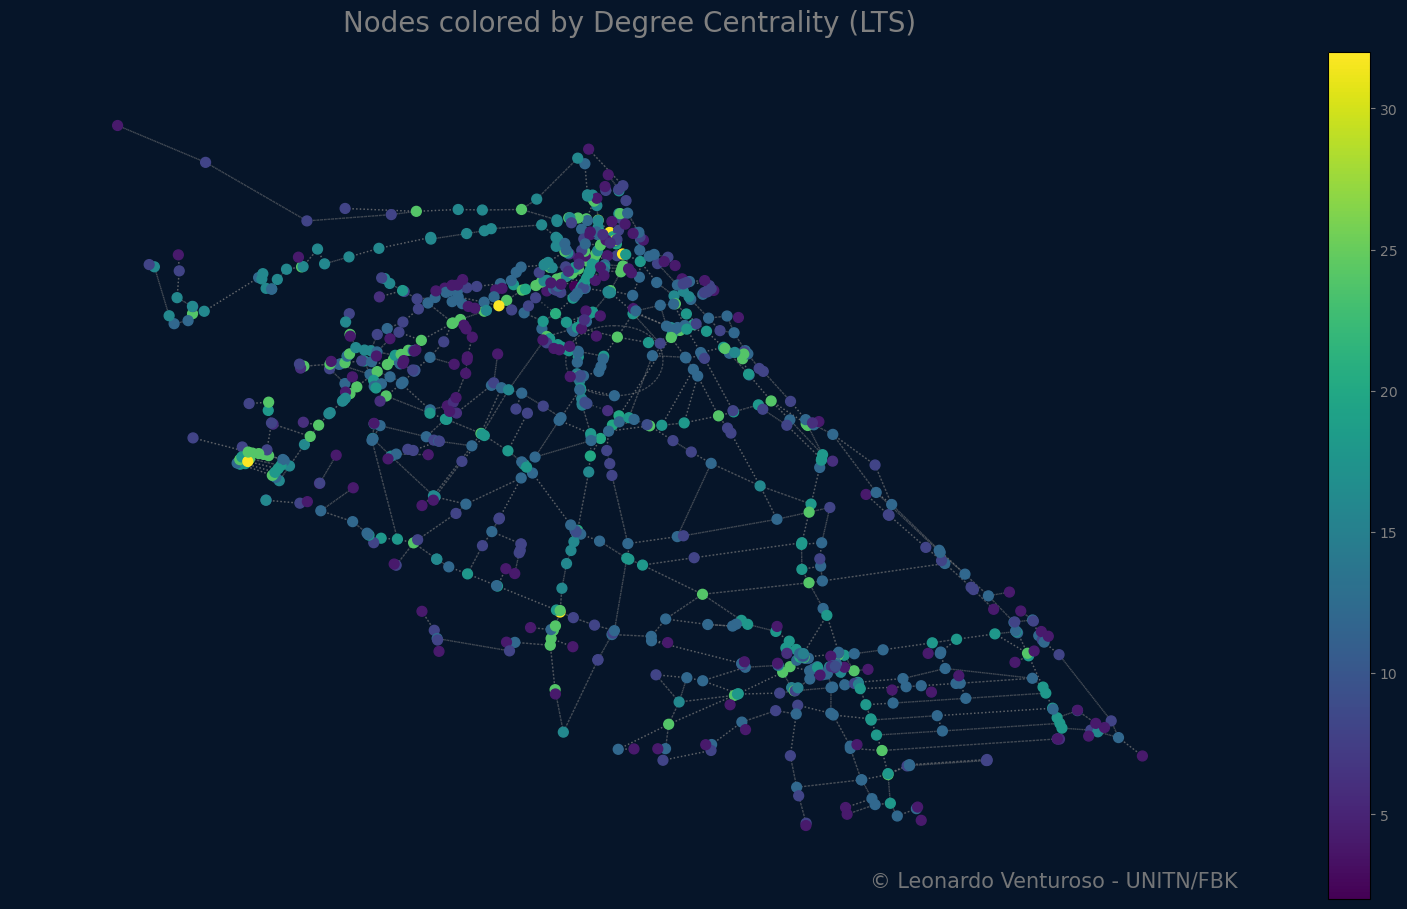

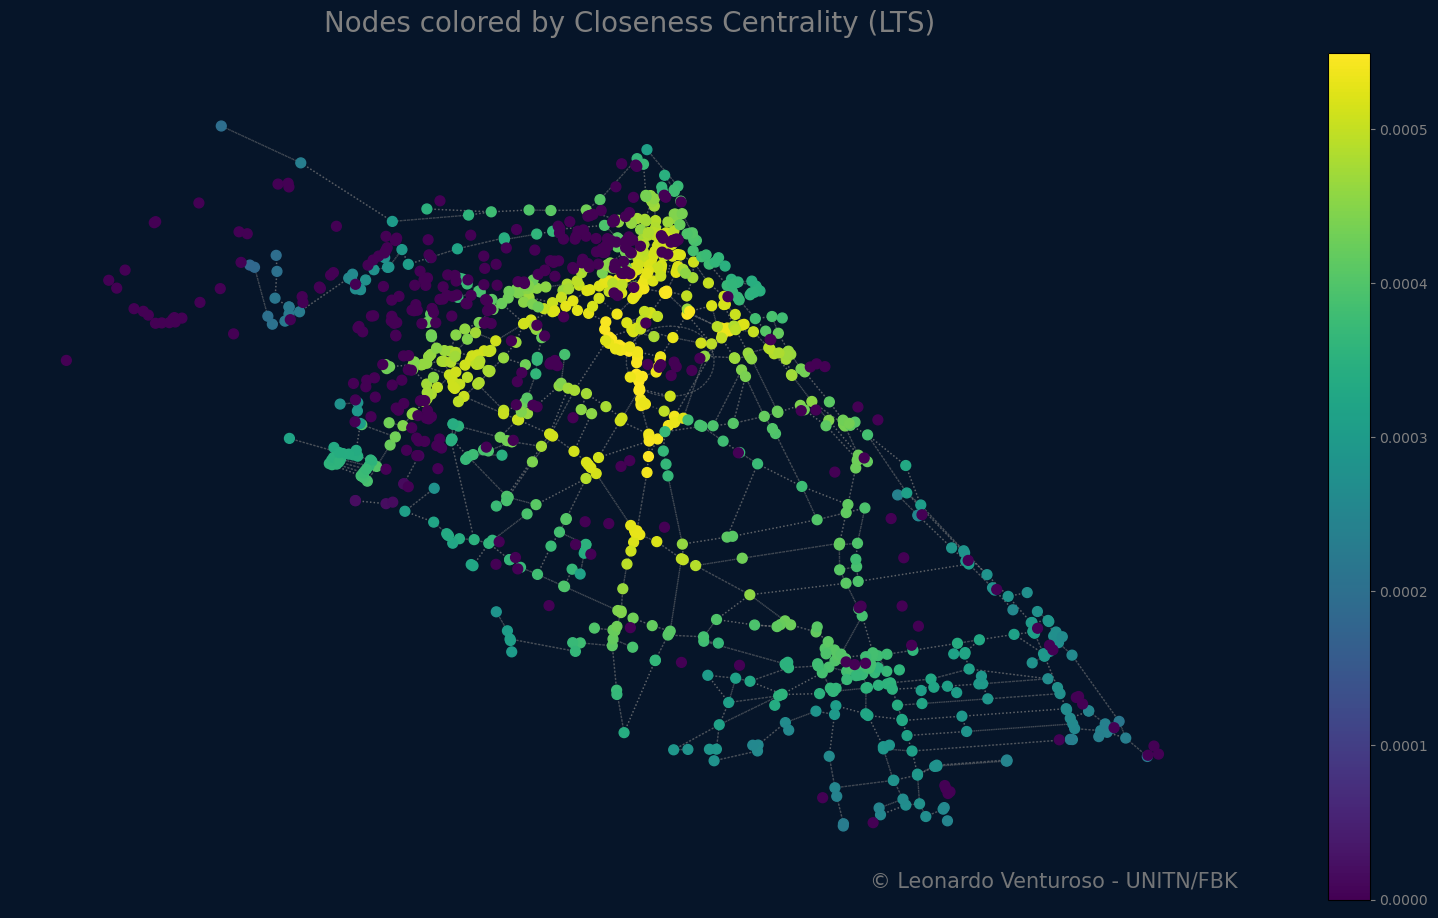

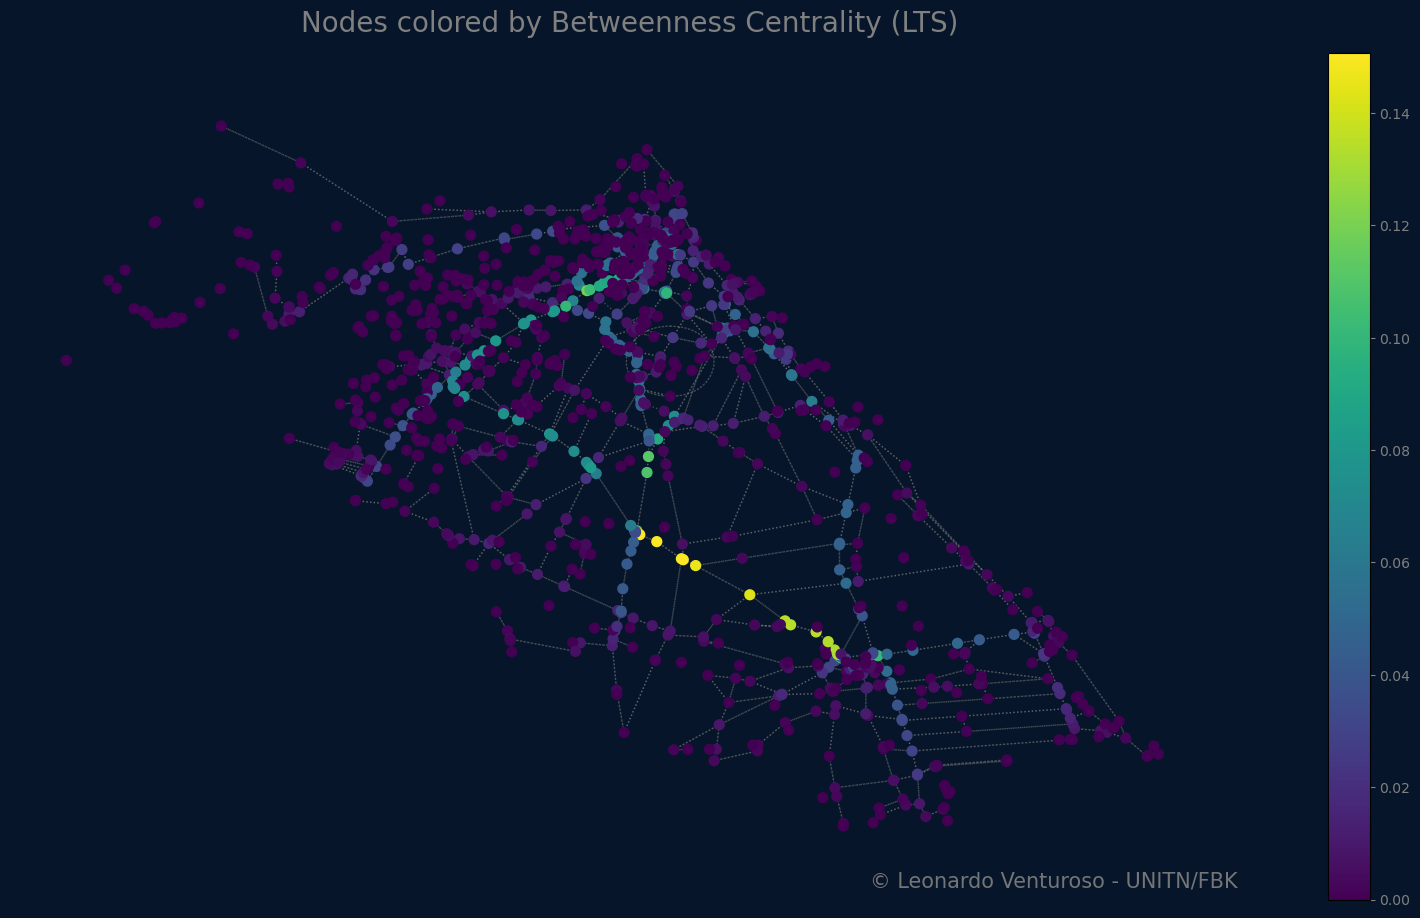

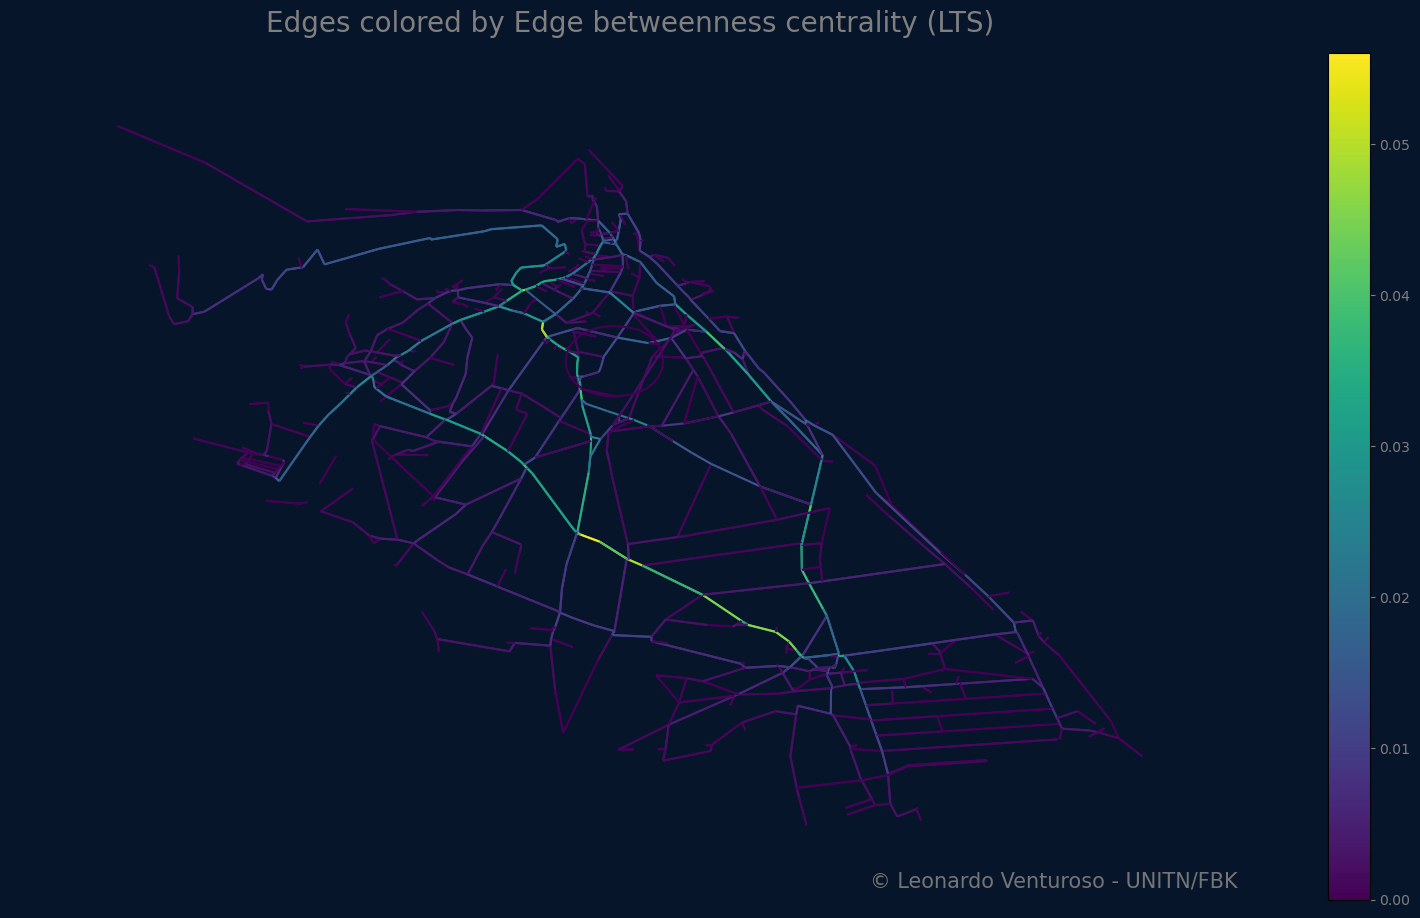

In [14]:
## Graphs for viz of centrality
    
## Visualize nodes based on Degree Centrality (LTS weighted)
image_file_path_5 = os.path.join(city_folder_path, "nodes_betweenness_centrality.png")
draw_graph(G_lts, degree_centrality, 'Nodes colored by Degree Centrality (LTS)', image_file_path_5)

## Visualize nodes based on Closeness Centrality (LTS weighted)
image_file_path_6 = os.path.join(city_folder_path, "nodes_closeness_centrality.png")
draw_graph(G_lts, closeness_centrality, 'Nodes colored by Closeness Centrality (LTS)', image_file_path_6)

## Visualize nodes based on Betweenness Centrality (LTS weighted)
image_file_path_7 = os.path.join(city_folder_path, "nodes_betweenness_centrality.png")
draw_graph(G_lts, betweenness_centrality, 'Nodes colored by Betweenness Centrality (LTS)', image_file_path_7)

## Visualize edges based on Edges Betweenness Centrality (LTS weighted)
fixed_edge_betweenness = {(u, v): value for (u, v, *_), value in edge_betweenness_centrality_values.items()}
image_file_path_8 = os.path.join(city_folder_path, "edgez_betweenness_centrality.png")
draw_edges(G_lts, fixed_edge_betweenness, "Edges colored by Edge betweenness centrality (LTS)", image_file_path_8)

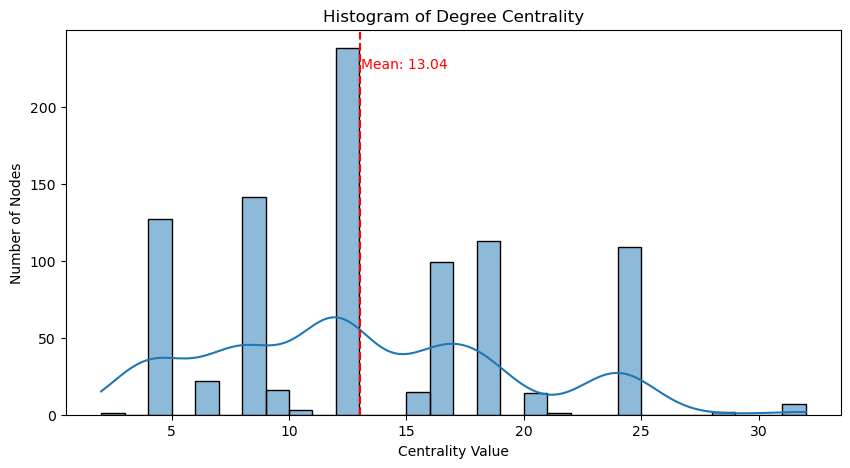

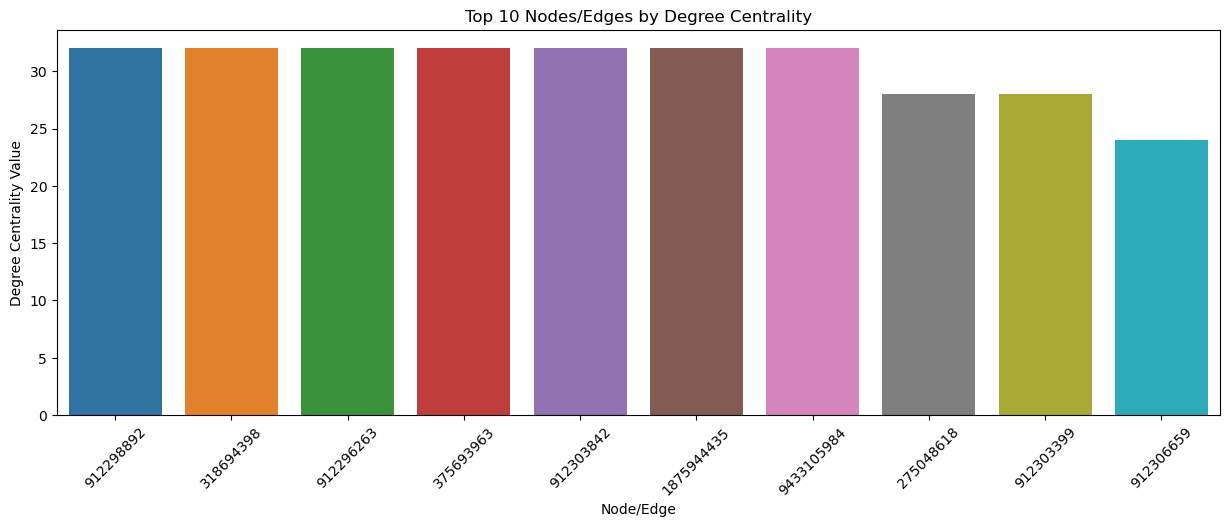

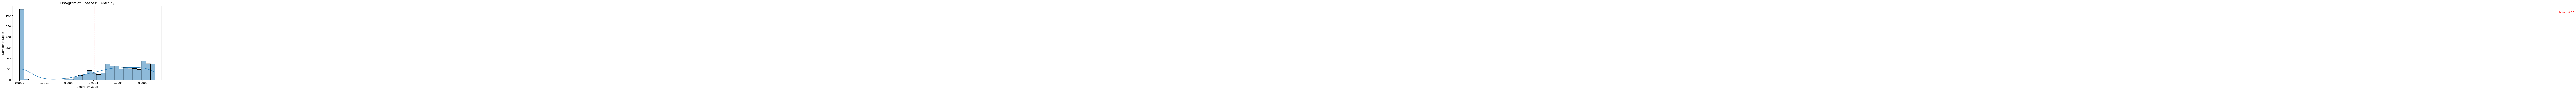

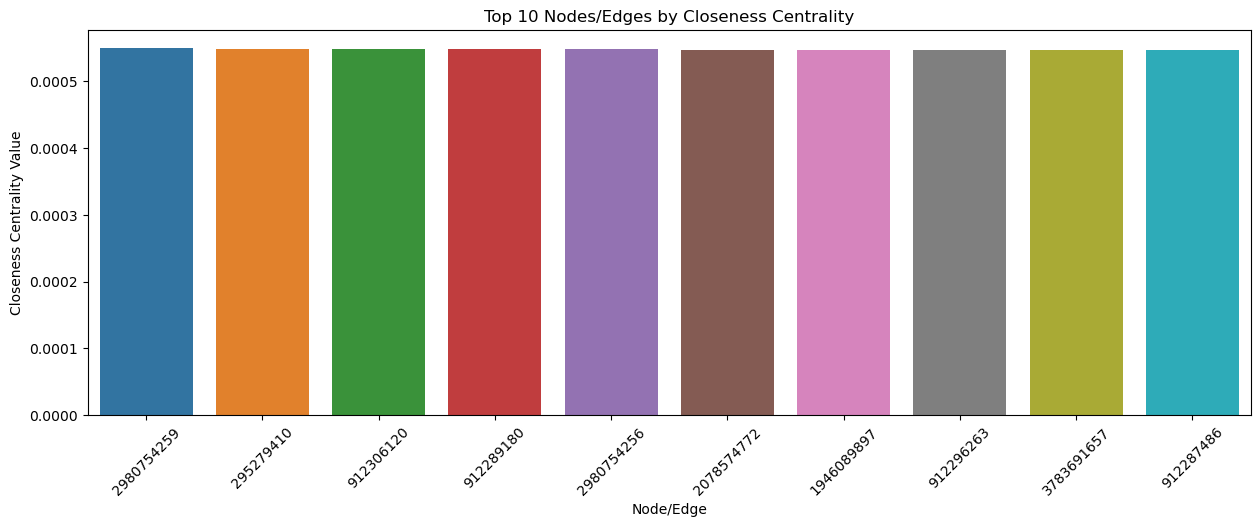

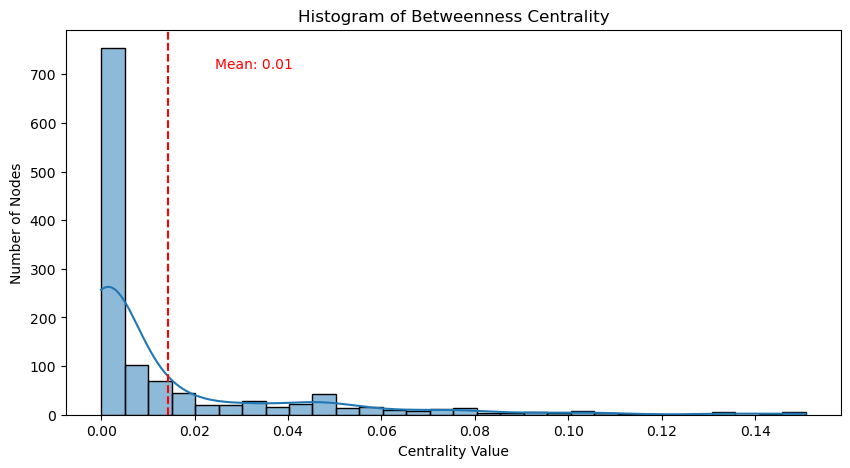

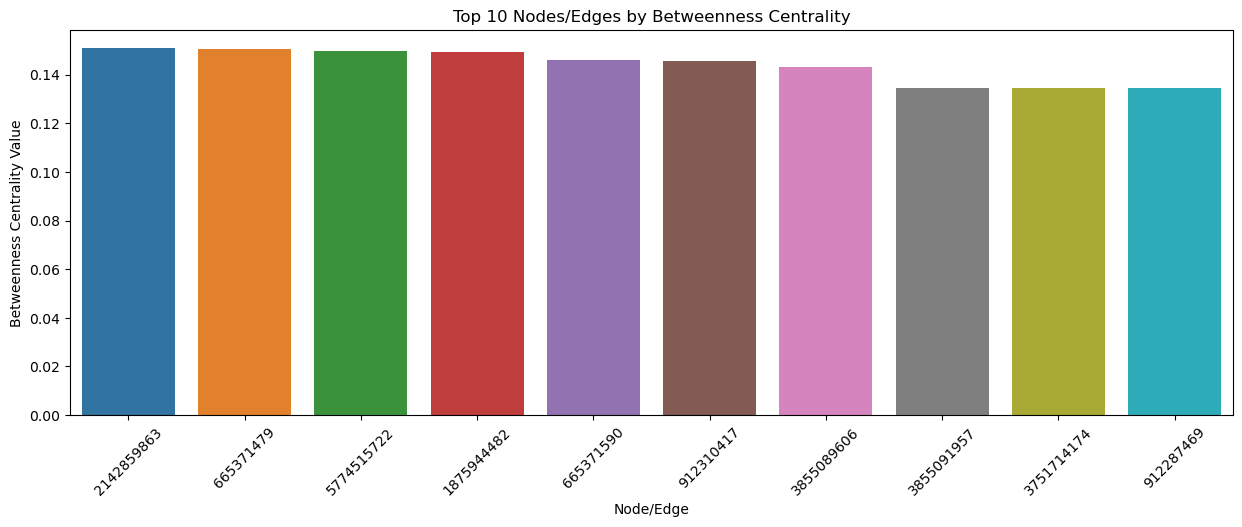

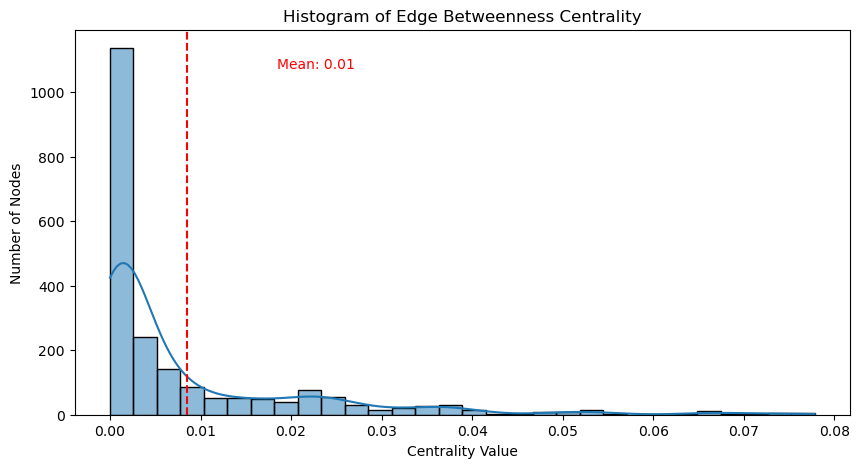

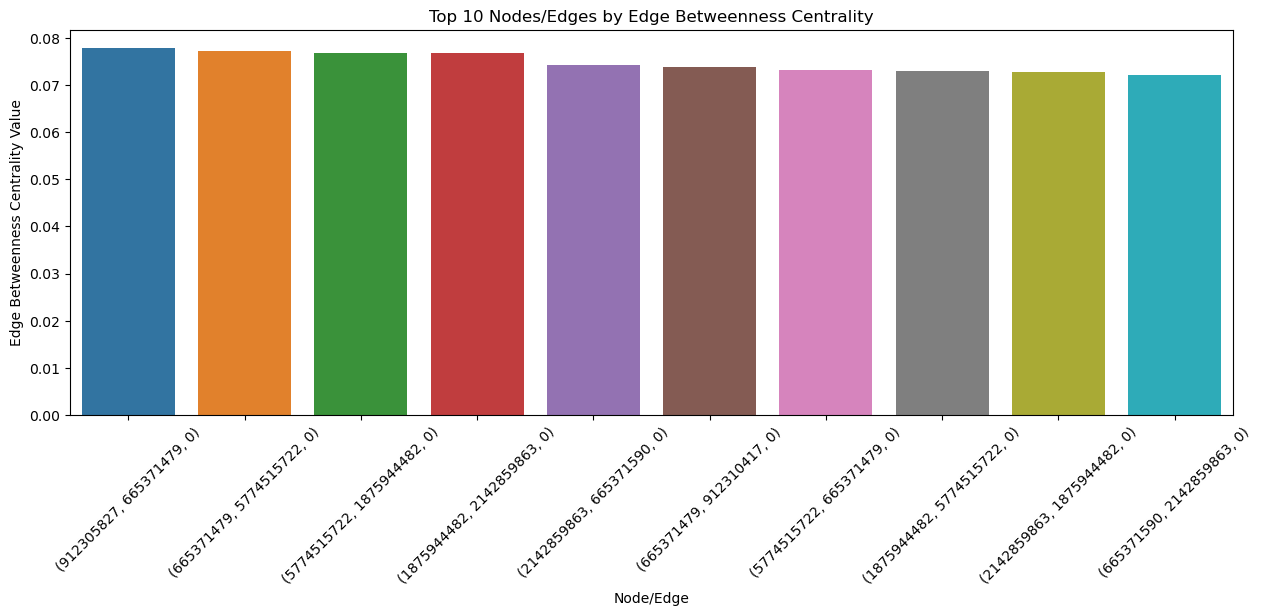

In [17]:
## Histograms for viz of centrality measures to understand the distribution of centrality scores across nodes.
## Bar plots for the top nodes in each centrality measure.

## Function to visualize centrality measures
def visualize_centrality(centrality_values, title, file_path):
    ## Histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(list(centrality_values.values()), bins=30, kde=True)

    # Display mean value
    mean_value = np.mean(list(centrality_values.values()))
    plt.axvline(mean_value, color='red', linestyle='--')
    plt.text(mean_value + 0.01, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', rotation=0)
    
    plt.title(f'Histogram of {title}')
    plt.xlabel('Centrality Value')
    plt.ylabel('Number of Nodes')
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
    plt.show()

    ## Bar plot for top nodes
    top_nodes = sorted(centrality_values.items(), key=lambda x: x[1], reverse=True)[:10]
    nodes, values = zip(*top_nodes)
    
    # Convert nodes (which can be tuples for edges) to strings for visualization
    nodes = [str(node) for node in nodes]
    
    plt.figure(figsize=(15, 5))
    sns.barplot(list(nodes), list(values))
    plt.title(f'Top 10 Nodes/Edges by {title}')
    plt.xlabel('Node/Edge')
    plt.ylabel(f'{title} Value')
    plt.xticks(rotation=45)
    plt.savefig(file_path.replace(".png", "_top_nodes.png"), bbox_inches='tight', dpi=300)
    plt.show()


## Visualize Degree Centrality
image_file_path = os.path.join(city_folder_path, "deg_central_map.png")
visualize_centrality(degree_centrality, 'Degree Centrality', image_file_path)

## Visualize Closeness Centrality
image_file_path = os.path.join(city_folder_path, "clos_central_map.png")
visualize_centrality(closeness_centrality, 'Closeness Centrality', image_file_path)

## Visualize Betweenness Centrality
image_file_path = os.path.join(city_folder_path, "betw_central_map.png")
visualize_centrality(betweenness_centrality, 'Betweenness Centrality', image_file_path)

## Visualize Edge Betweenness Centrality
image_file_path = os.path.join(city_folder_path, "edge_bet_central_map.png")
visualize_centrality(edge_betweenness_centrality, 'Edge Betweenness Centrality', image_file_path )

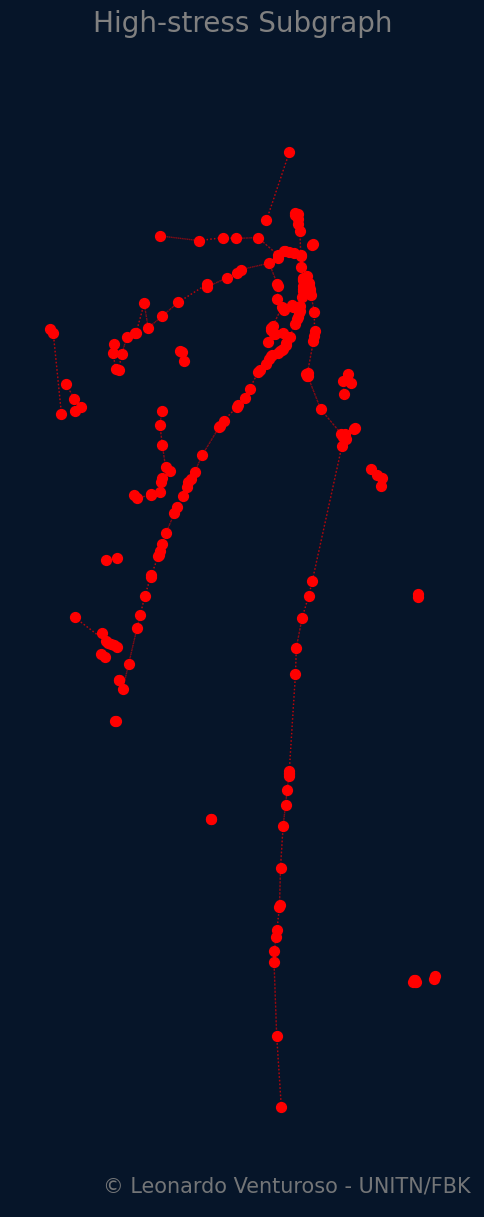

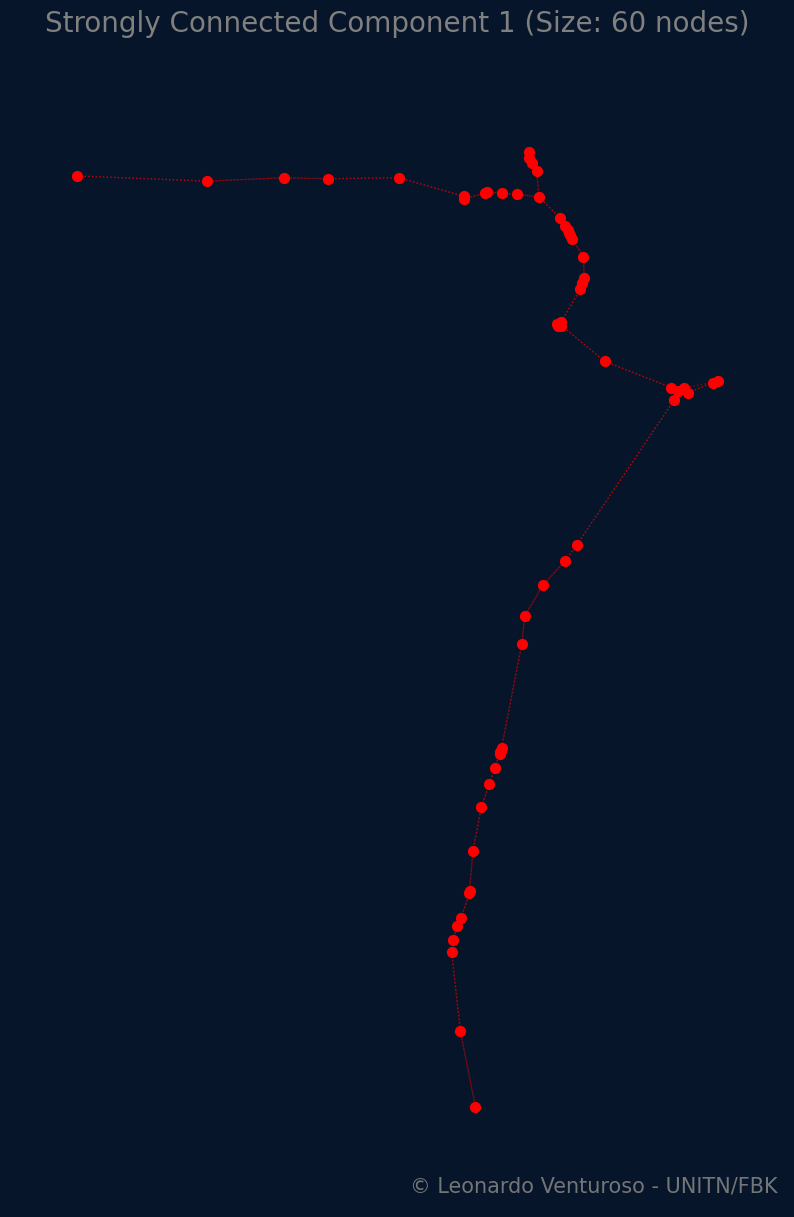

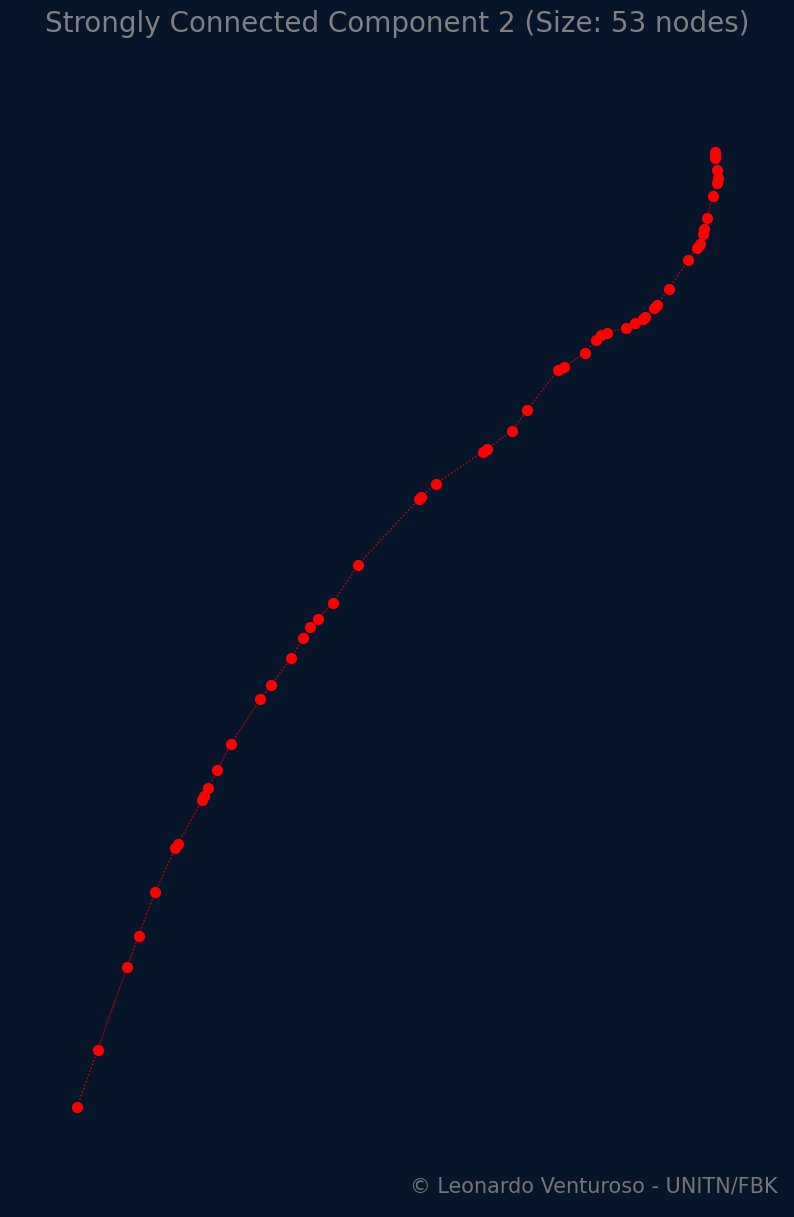

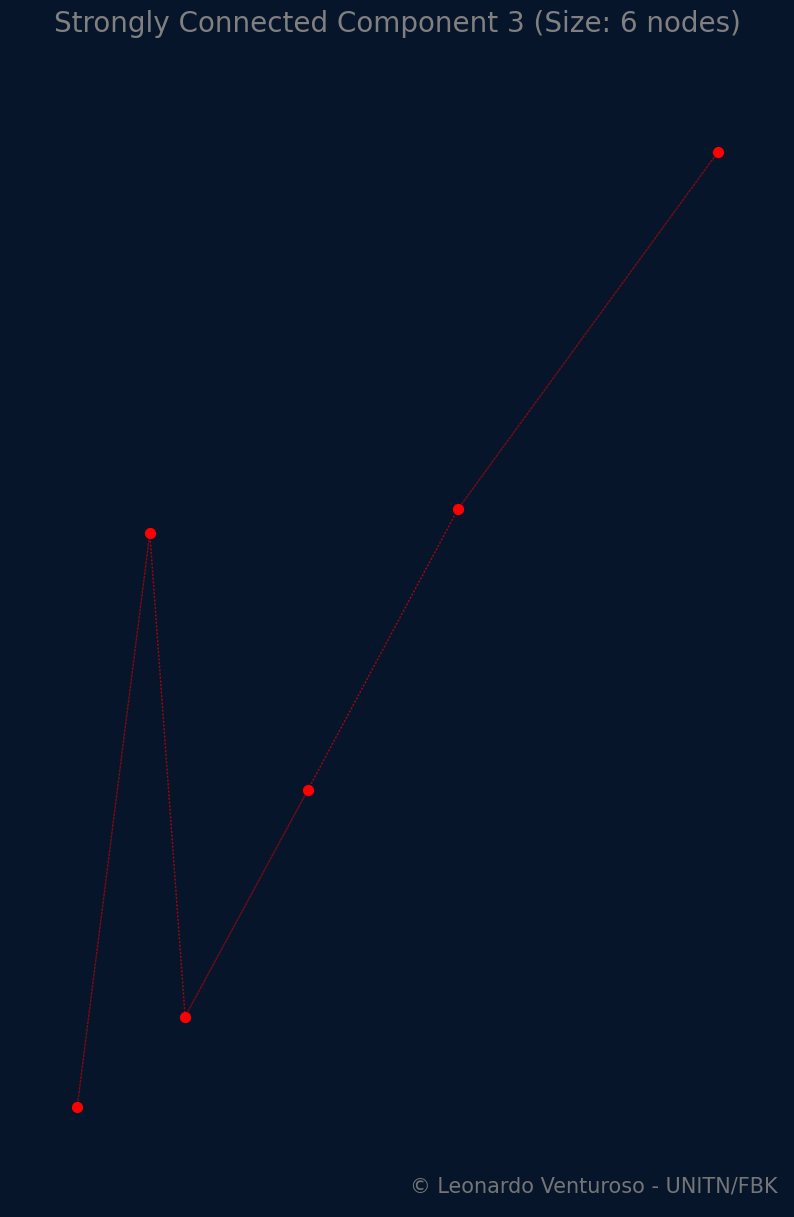

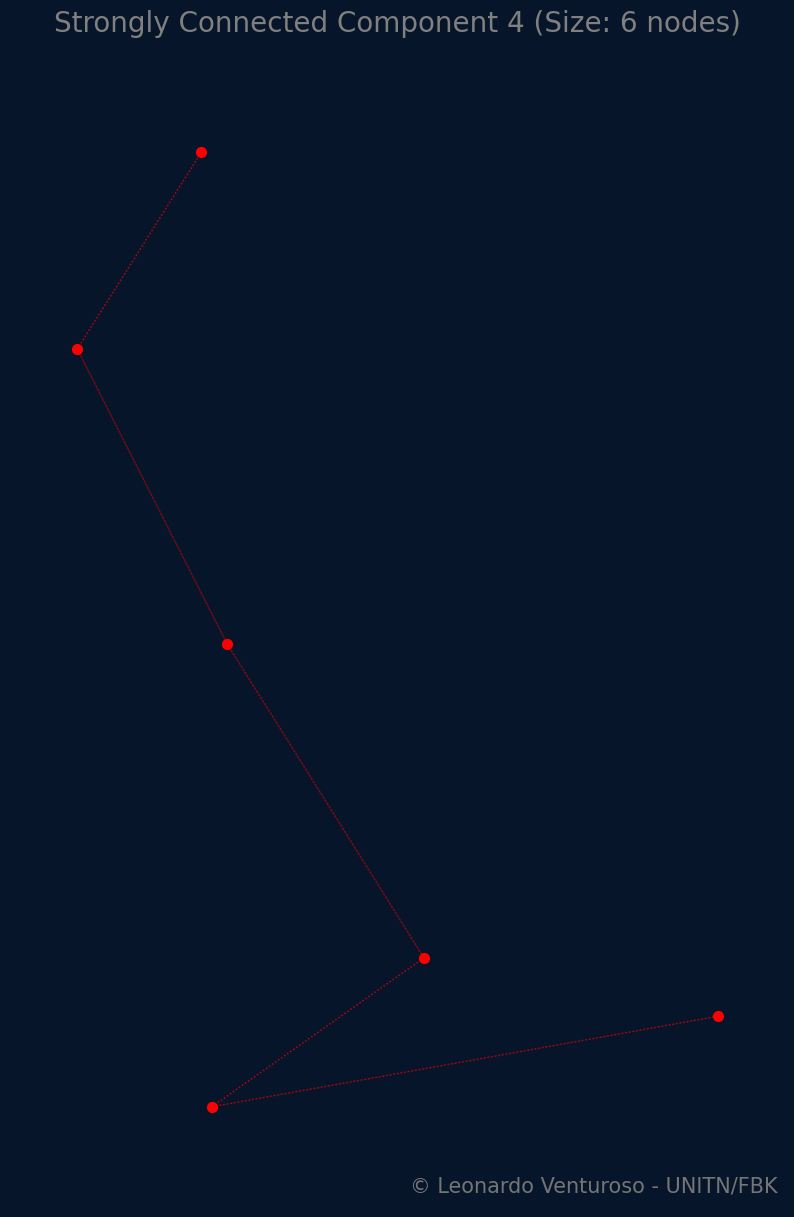

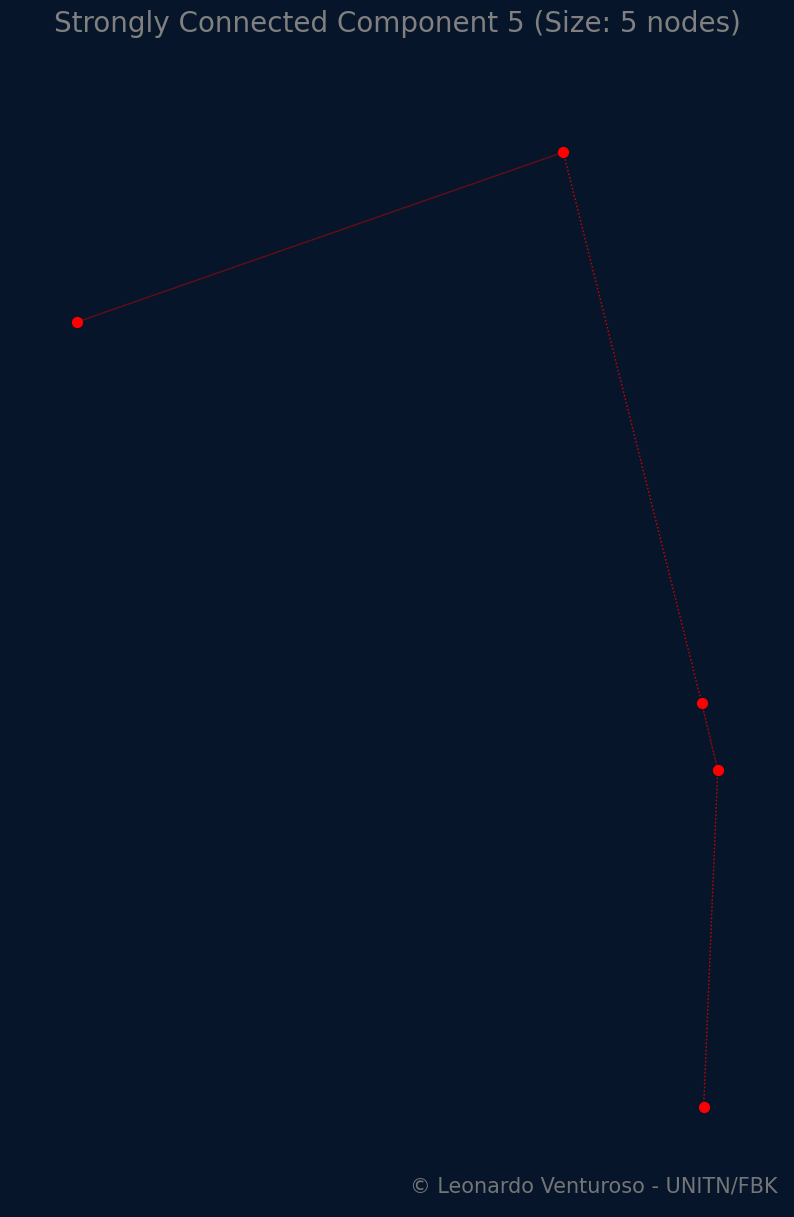

In [22]:
## Graphs for visualizing the SCC and high-stress subgraphs.
 
def visualize_high_stress_subgraph(subgraph, file_path):
    """
    Visualizes the high-stress subgraph with a specified style.
    """
    # Use geographical coordinates for positioning
    pos = {node: (data['x'], data['y']) for node, data in subgraph.nodes(data=True)}

    # Figure setup
    fig, ax = plt.subplots(figsize=(6, 15))
    ax.set_facecolor("#061529")
    fig.set_facecolor("#061529")

    # Draw nodes and edges
    nx.draw_networkx_nodes(G=subgraph, pos=pos, node_color="red", alpha=1, node_size=50)
    nx.draw_networkx_edges(G=subgraph, pos=pos, edge_color='red', style="dotted", alpha=0.5, arrows=False)

    # Labeling Axes
    ax.set_title("High-stress Subgraph", fontdict={"fontsize": 20, "color": "grey"}, pad=15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Leonardo Venturoso - UNITN/FBK',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha=0.9)
    
    plt.savefig(image_file_path, bbox_inches='tight', dpi=300)
    plt.show()

def visualize_largest_strongly_connected_components(components, G, n=5, image_folder=None):
    """
    Visualizes the top n largest strongly connected components of the graph with a specified style.
    """
    # Sort the components by size in descending order
    sorted_components = sorted(components, key=len, reverse=True)

    # Use geographical coordinates for positioning
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

    for i, component in enumerate(sorted_components[:n]):
        subgraph = G.subgraph(component)

        # Figure setup
        fig, ax = plt.subplots(figsize=(10, 15))
        ax.set_facecolor("#061529")
        fig.set_facecolor("#061529")

        # Draw nodes and edges
        nx.draw_networkx_nodes(G=subgraph, pos=pos, node_color="red", alpha=1, node_size=50)
        nx.draw_networkx_edges(G=subgraph, pos=pos, edge_color='red', style="dotted", alpha=0.5, arrows=False)

        # Labeling Axes
        ax.set_title(f"Strongly Connected Component {i + 1} (Size: {len(component)} nodes)", fontdict={"fontsize": 20, "color": "grey"}, pad=15)
        ax.axis('off')

        # Watermark
        ax.text(0.99, 0.01, '© Leonardo Venturoso - UNITN/FBK',
                verticalalignment='bottom',
                horizontalalignment='right',
                transform=ax.transAxes,
                color='grey',
                fontsize=15,
                alpha=0.9)

        if image_folder:
            # Generate a unique filename for each image
            image_filename = f"component_{i + 1}.png"
            image_file_path = os.path.join(image_folder, image_filename)
            plt.savefig(image_file_path, bbox_inches='tight', dpi=300)
        else:
            plt.show()

image_file_path = os.path.join(city_folder_path, "g_high_stres_map.png")
visualize_high_stress_subgraph(G_high_stress, image_file_path)
image_folder = city_folder_path
visualize_largest_strongly_connected_components(high_stress_subgraphs, G_high_stress, image_folder=image_folder)

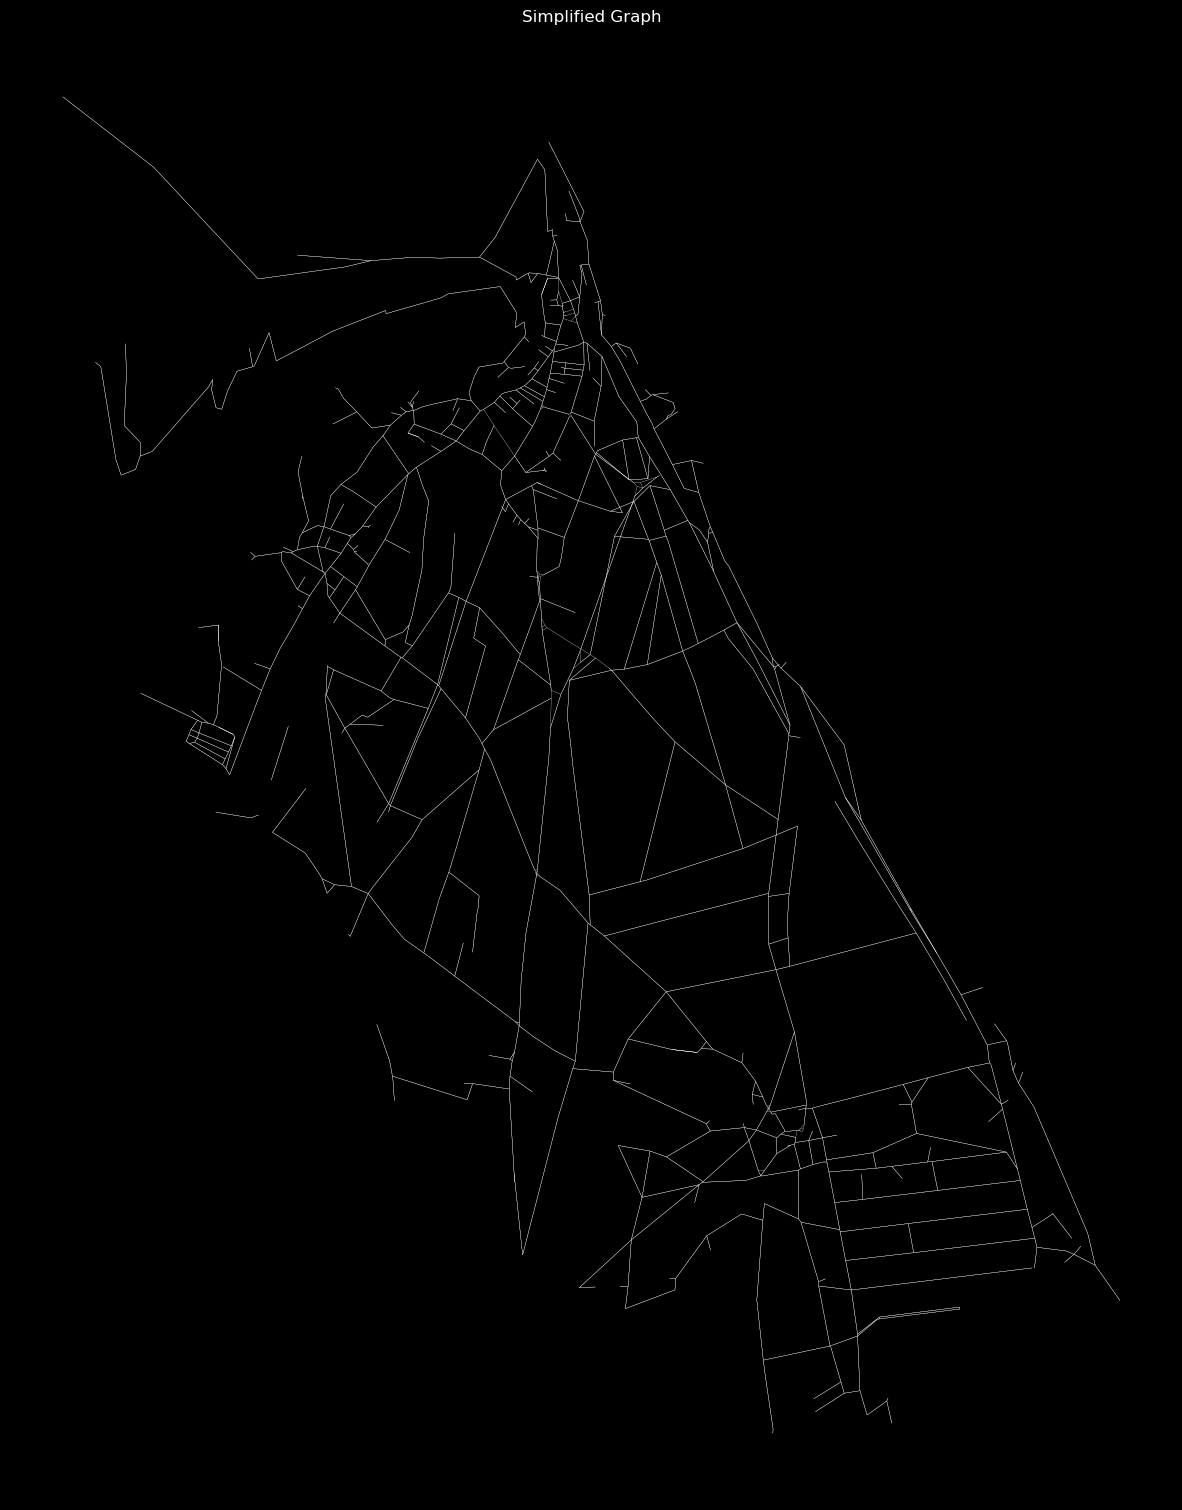

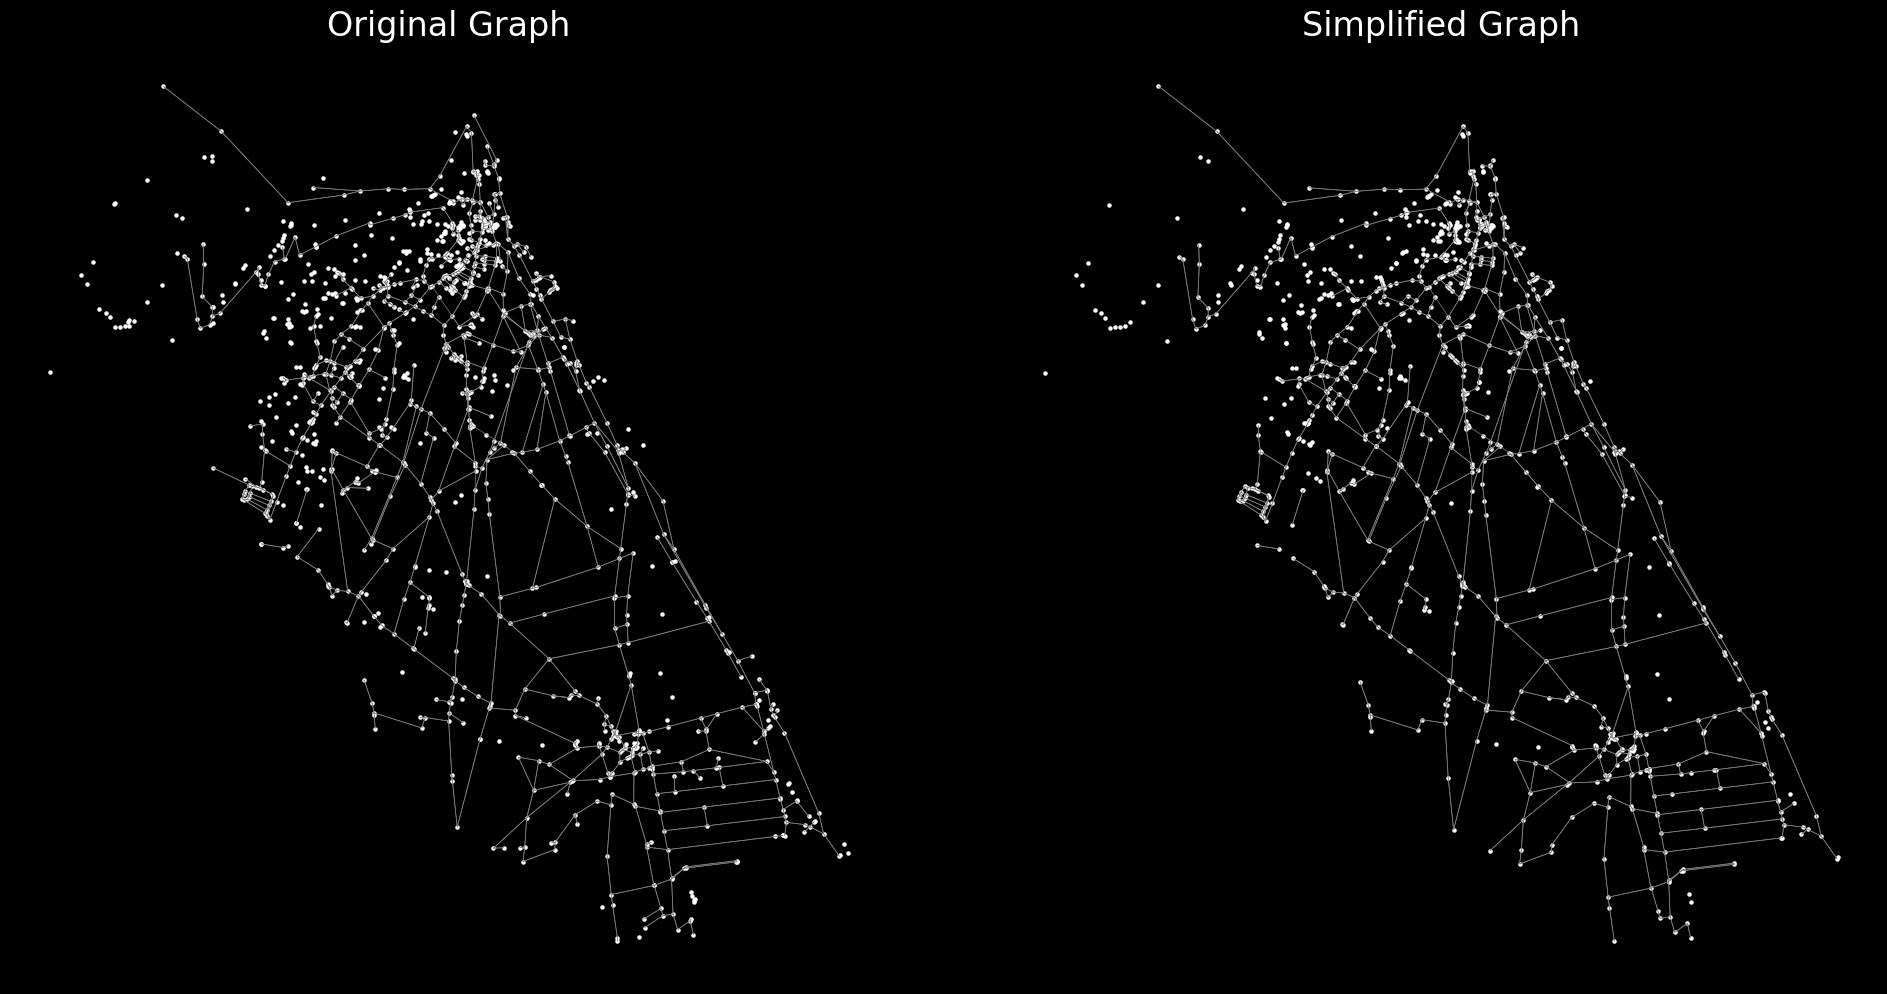

The number of nodes are:

 - in the original graph: 1233
 - in the simplified graph: 981


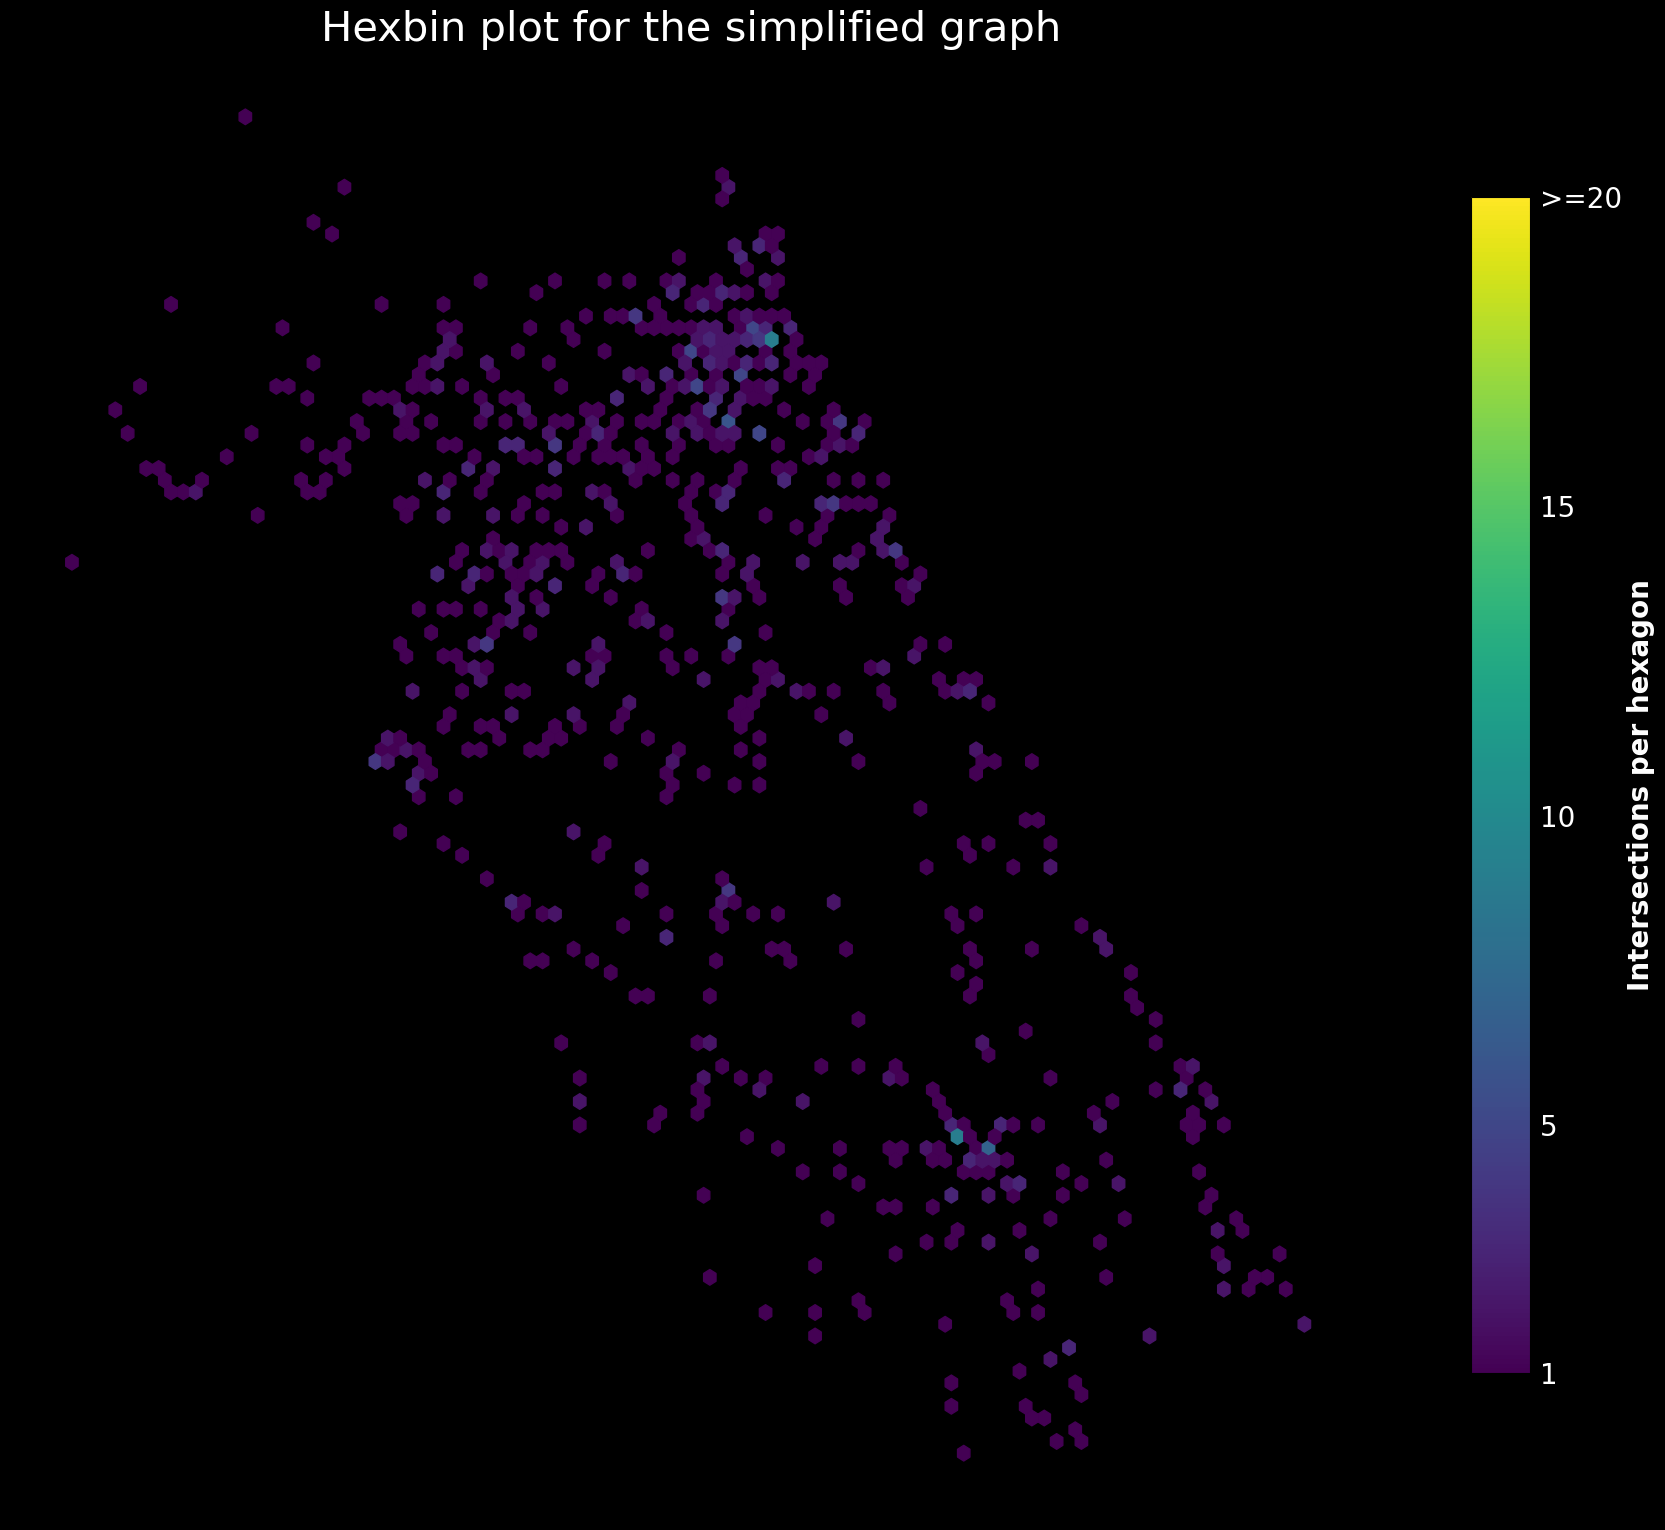

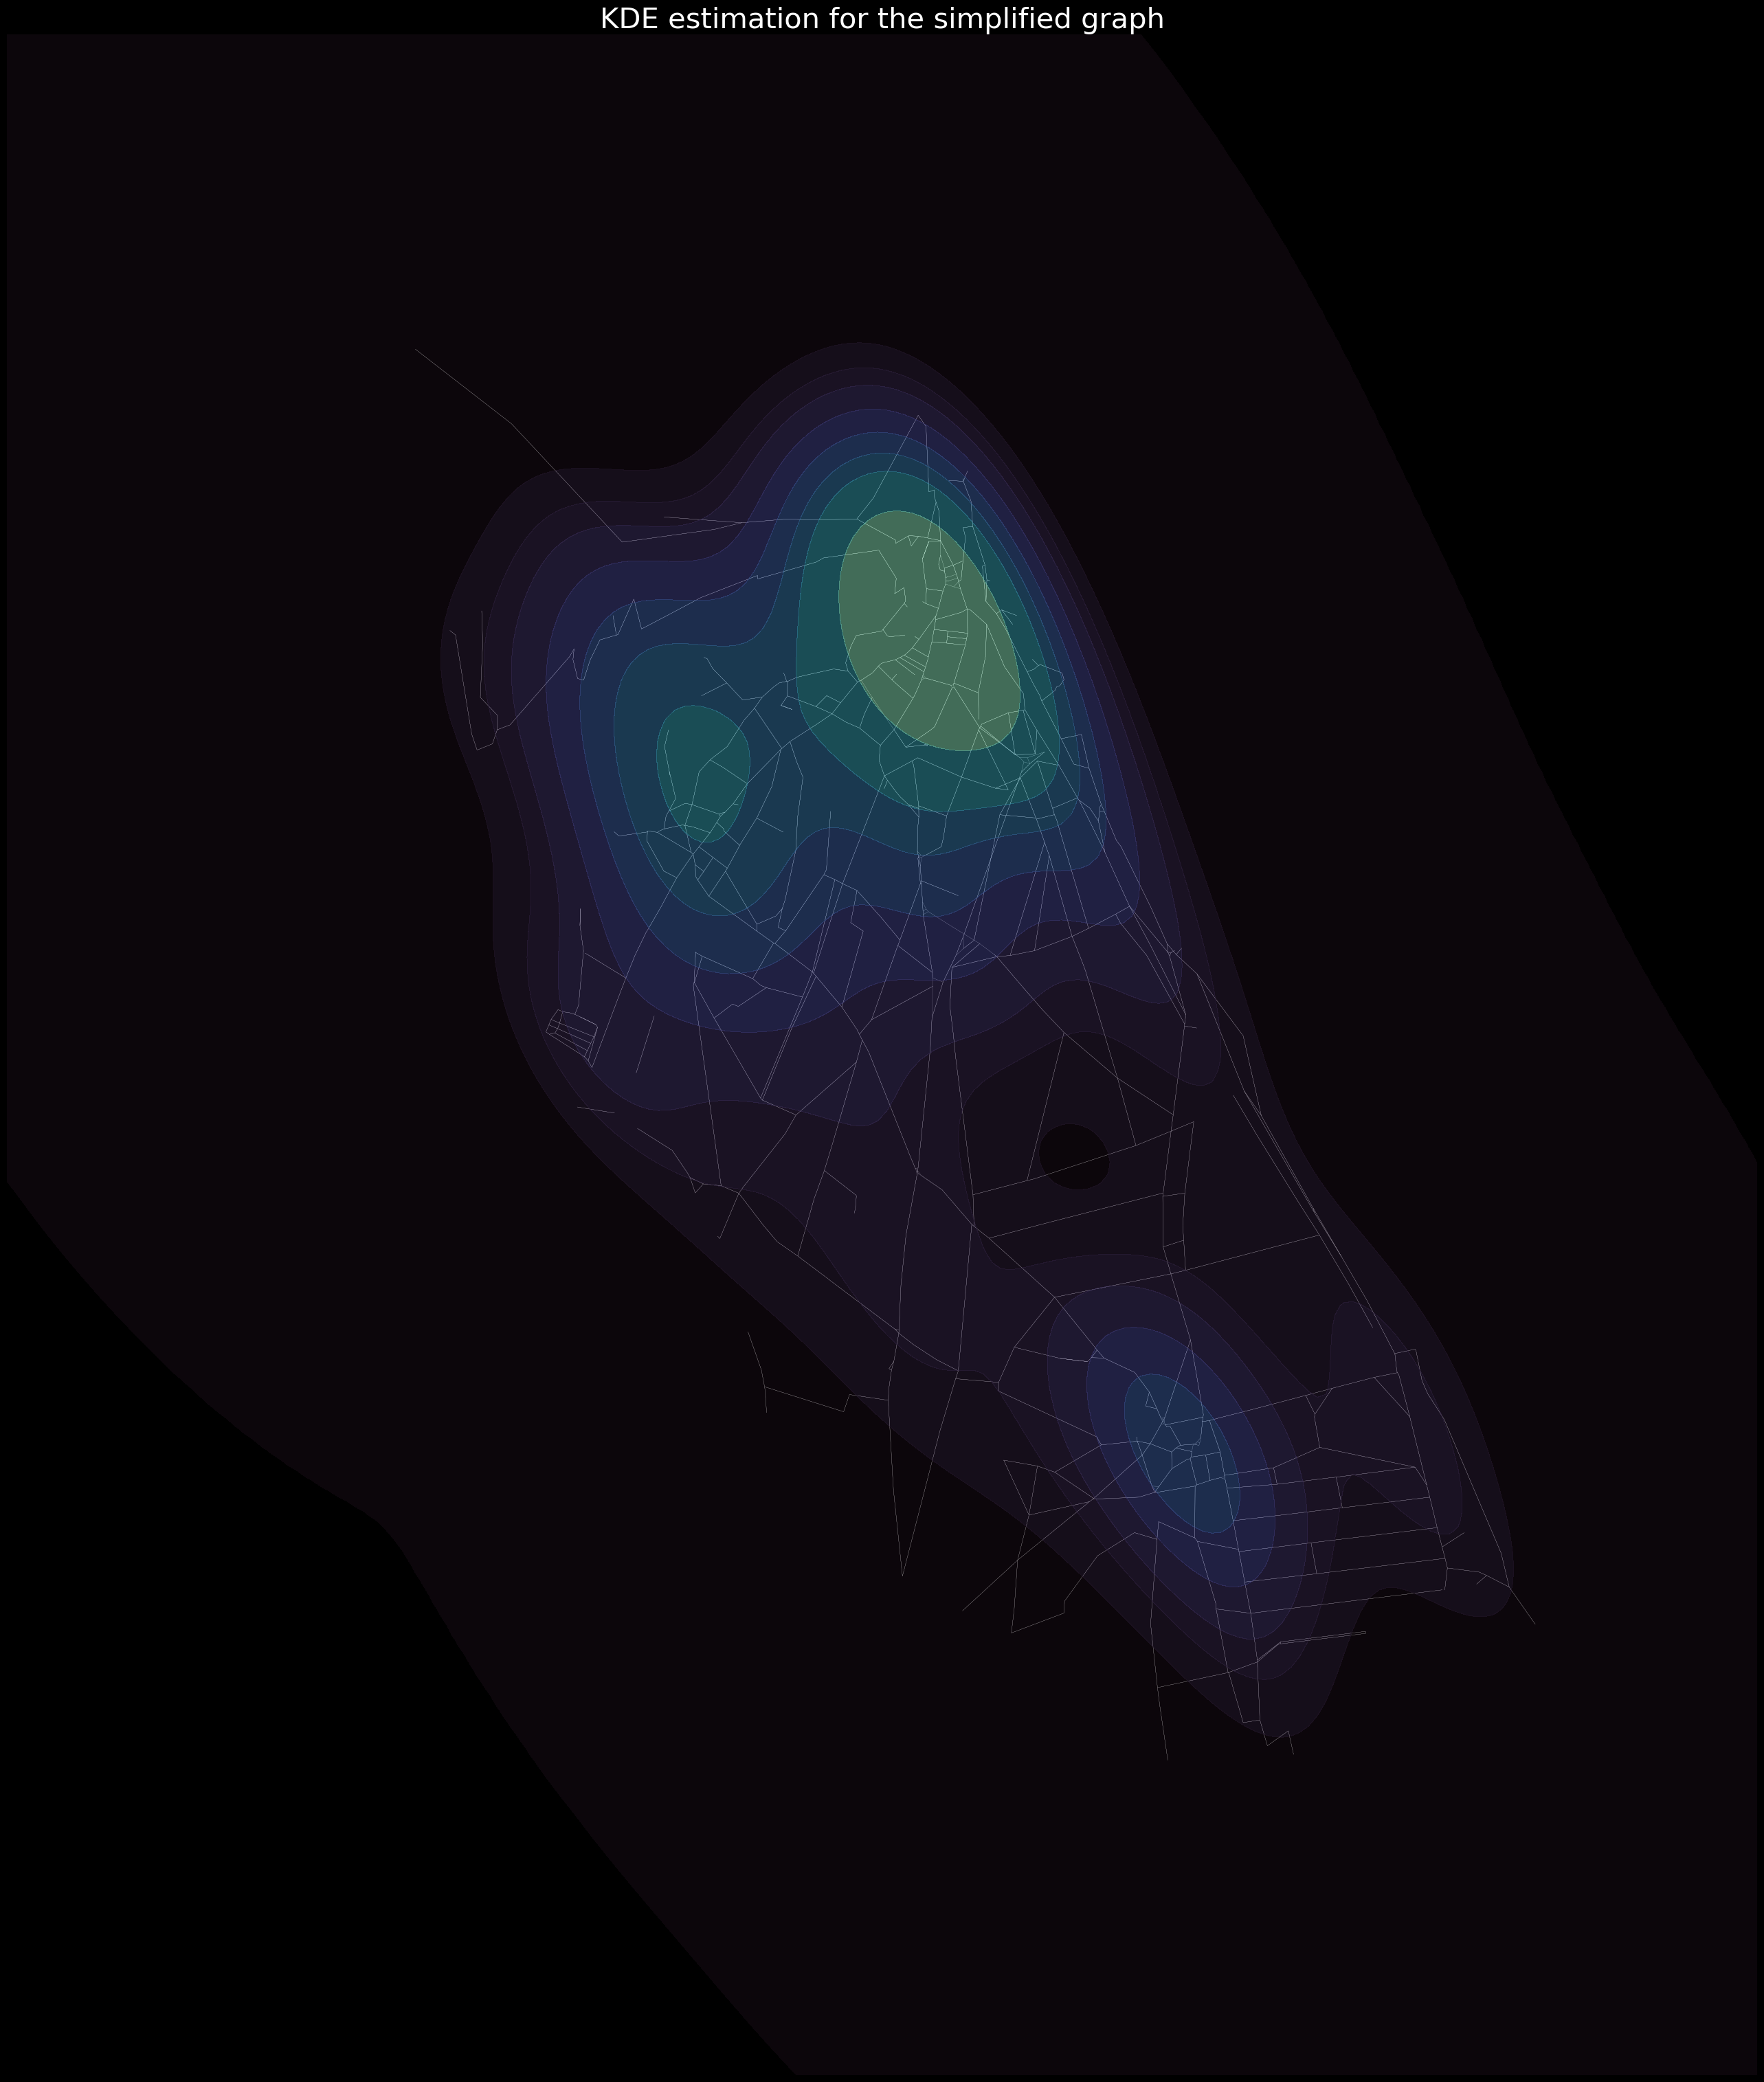

In [27]:
## Intersection density as an indicator of bikeability
'''
Intersection density tells us how dense and connected a street network is. These indicators are directly linked with how bikeable 
a place is. An area with a dense network has fewer inaccessible spots in it, and a high connectivity makes for more diverse and 
efficient route possibilities. Scientific literature backs this up: a positive correlation between intersection density 
and biking as a transport method has been consistently demonstrated.
'''
# Simplify the graph to retain real intersections only, by consolidating nodes that are close to each other.
graph_simplified = ox.simplification.consolidate_intersections(G_lts, tolerance=5, 
       rebuild_graph=True, dead_ends=False, reconnect_edges=True)

# Convert the original and simplified graphs to Geopandas DataFrames.
nodes, edges = ox.graph_to_gdfs(G_lts)
nodes_s, edges_s = ox.graph_to_gdfs(graph_simplified)

'''The resulting graph is very dense and has a ton of nodes. This can be problematic. 
For example, if two paths merge with a third path at just slightly different points, 
one real-life intersecion can turn into 2 nodes. In this analysis my aim was to 
model actual intersections only, which is why I chose to simplify the graph a bit. 
I dissolved all nodes within five meters of each other into single nodes and excluded all dead-ends. 
'''

def plot_graphs(edges, nodes, edges_s, nodes_s, title1="Original Graph", title2="Simplified Graph", save_path=None):
    # Plot the original graph
    fig, ax = plt.subplots(figsize=(20,15))
    ax.set_axis_off()
    ax.set_aspect('equal')
    fig.set_facecolor('black')
    edges.plot(ax=ax, color='white', linewidth=0.2)
    plt.tight_layout()
    plt.title("Simplified Graph")
    if save_path:
        plt.savefig(os.path.join(save_path, f"{title1}.png"))
    plt.show()

    # Define colors
    edgecol = [0.5,0.5,0.5]
    nodecol = 'white'
    linewidth = 0.5
    markersize = 5

    # Setup plot
    fig, ax = plt.subplots(ncols=2, figsize=(20,10))
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    fig.set_facecolor('black')

    # Add titles
    ax[0].set_title(title1, fontsize=24, color='white')
    ax[1].set_title(title2, fontsize=24, color='white')

    # Plot original graph
    edges.plot(ax=ax[0], color=edgecol, linewidth=linewidth)
    nodes.plot(ax=ax[0], color=nodecol, markersize=markersize)

    # Plot simplified graph
    edges_s.plot(ax=ax[1], color=edgecol, linewidth=linewidth)
    nodes_s.plot(ax=ax[1], color=nodecol, markersize=markersize)

    # Tight layout 
    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, f"{title2}.png"))
    plt.show()

# Example usage:
plot_graphs(edges, nodes, edges_s, nodes_s, save_path=city_folder_path)

print('The number of nodes are:\n\n - in the original graph: '+str(len(nodes))
     +'\n - in the simplified graph: '+str(len(nodes_s)))

''' To better visualize the spatial variance in the intersection density I use these graphs below'''

def plot_hexbin(nodes, figsize=(20,15), gridsize=100, vmax=20, colorbar_ticks=[1, 5, 10, 15, 20], label='Intersections per hexagon', save_path=None):
    """
    Plot the nodes as hexbins.

    Parameters:
    - nodes: DataFrame containing 'x' and 'y' columns for the nodes' positions.
    - figsize: Size of the figure to be plotted.
    - gridsize: Number of hexagons in the x-direction.
    - vmax: Maximum count for a bin. 
    - colorbar_ticks: Ticks to display on the colorbar.
    - label: Label for the colorbar.
    -  save_path: Path where the plot should be saved.
    """

    # Set all text color to white
    COLOR = 'white'
    plt.rcParams['text.color'] = COLOR
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR

    # Setup plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_axis_off()
    ax.set_aspect('equal')
    fig.set_facecolor('black')

    # Plot as hexbins
    hb = ax.hexbin(
        x=nodes['x'],
        y=nodes['y'],
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        vmax=vmax,
    )

    # Colorbar
    cb = plt.colorbar(hb, ax=ax, shrink=0.8, ticks=colorbar_ticks)
    cb.ax.tick_params(color='none', labelsize=20)
    ytick_labels = [str(tick) for tick in colorbar_ticks[:-1]] + [f">={colorbar_ticks[-1]}"]
    cb.ax.set_yticklabels(ytick_labels)
    cb.set_label(label, fontsize=20, fontweight='bold')

    # Tight layout
    plt.tight_layout()
    plt.title("Hexbin plot for the simplified graph", fontsize=30, color="white")
    if save_path:
        plt.savefig(os.path.join(save_path, "hexbin_plot.png"))
    plt.show()

# Use:
plot_hexbin(nodes_s, save_path=city_folder_path)


def plot_kde_on_map(edges, nodes, figsize=(30,30), edge_color=[1,1,1], edge_linewidth=0.2, cmap='mako', kde_alpha=0.5, kde_levels=10, save_path=None):
    """
    Plot the KDE (Kernel Density Estimation) on top of the streets.

    Parameters:
    - edges: DataFrame for the streets/edges to be plotted.
    - nodes: DataFrame containing 'x' and 'y' columns for the nodes' positions.
    - figsize: Size of the figure to be plotted.
    - edge_color: Color for the streets/edges.
    - edge_linewidth: Linewidth for the streets/edges.
    - cmap: Colormap for the KDE plot.
    - kde_alpha: Transparency for the KDE plot.
    - kde_levels: Number of contour levels for the KDE plot.
    """

    # Setup plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_axis_off()
    ax.set_aspect('equal')
    fig.set_facecolor('black')

    # Plot streets underneath
    edges.plot(ax=ax, color=edge_color, linewidth=edge_linewidth, zorder=0)

    # Plot KDE on top
    sns.kdeplot(
        ax=ax,
        data=nodes,
        x='x', y='y',
        hue=None,
        fill=True,
        cmap=cmap,
        thresh=0,
        levels=kde_levels,
        alpha=kde_alpha,
        zorder=10
    )

    # Tight layout
    plt.tight_layout()
    plt.title("KDE estimation for the simplified graph", fontsize=30, color='white')
    if save_path:
        plt.savefig(os.path.join(save_path, "kde_est_simplifiedgraph.png"))
    plt.show()

# Use:
plot_kde_on_map(edges_s, nodes_s, save_path=city_folder_path)

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 1233
Setting CH edge vector of size 2135
Range graph removed 2064 edges of 4270
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

/Users/leonardo/opt/anaconda3/lib/python3.9/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/leonardo/opt/anaconda3/lib/python3.9/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


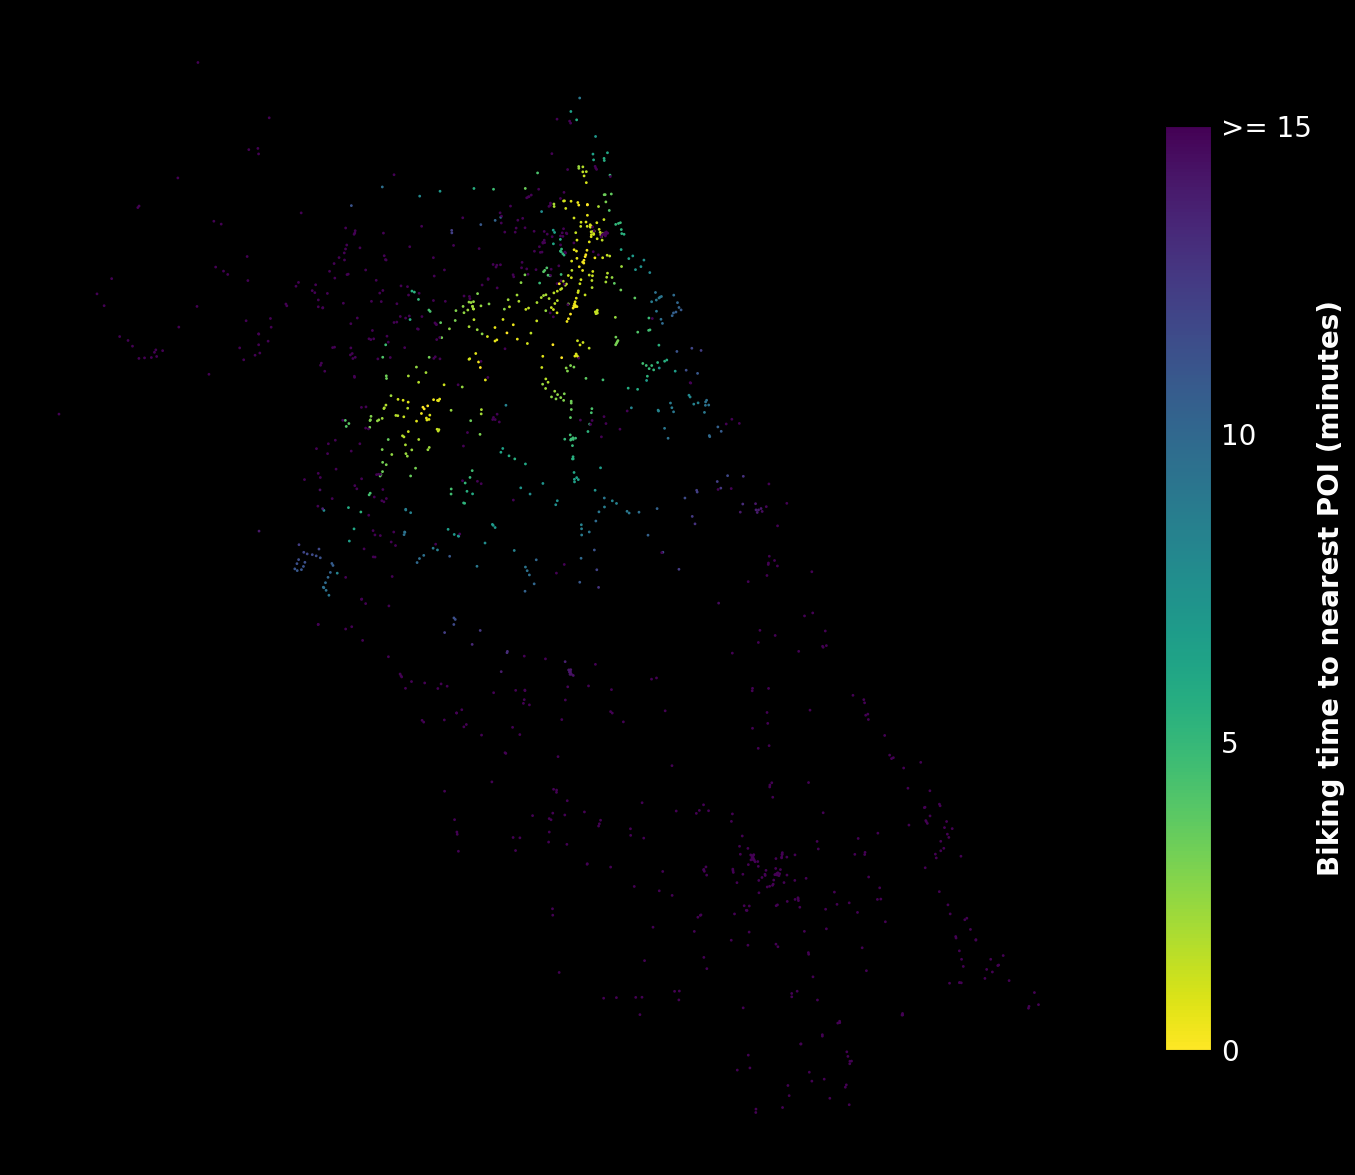

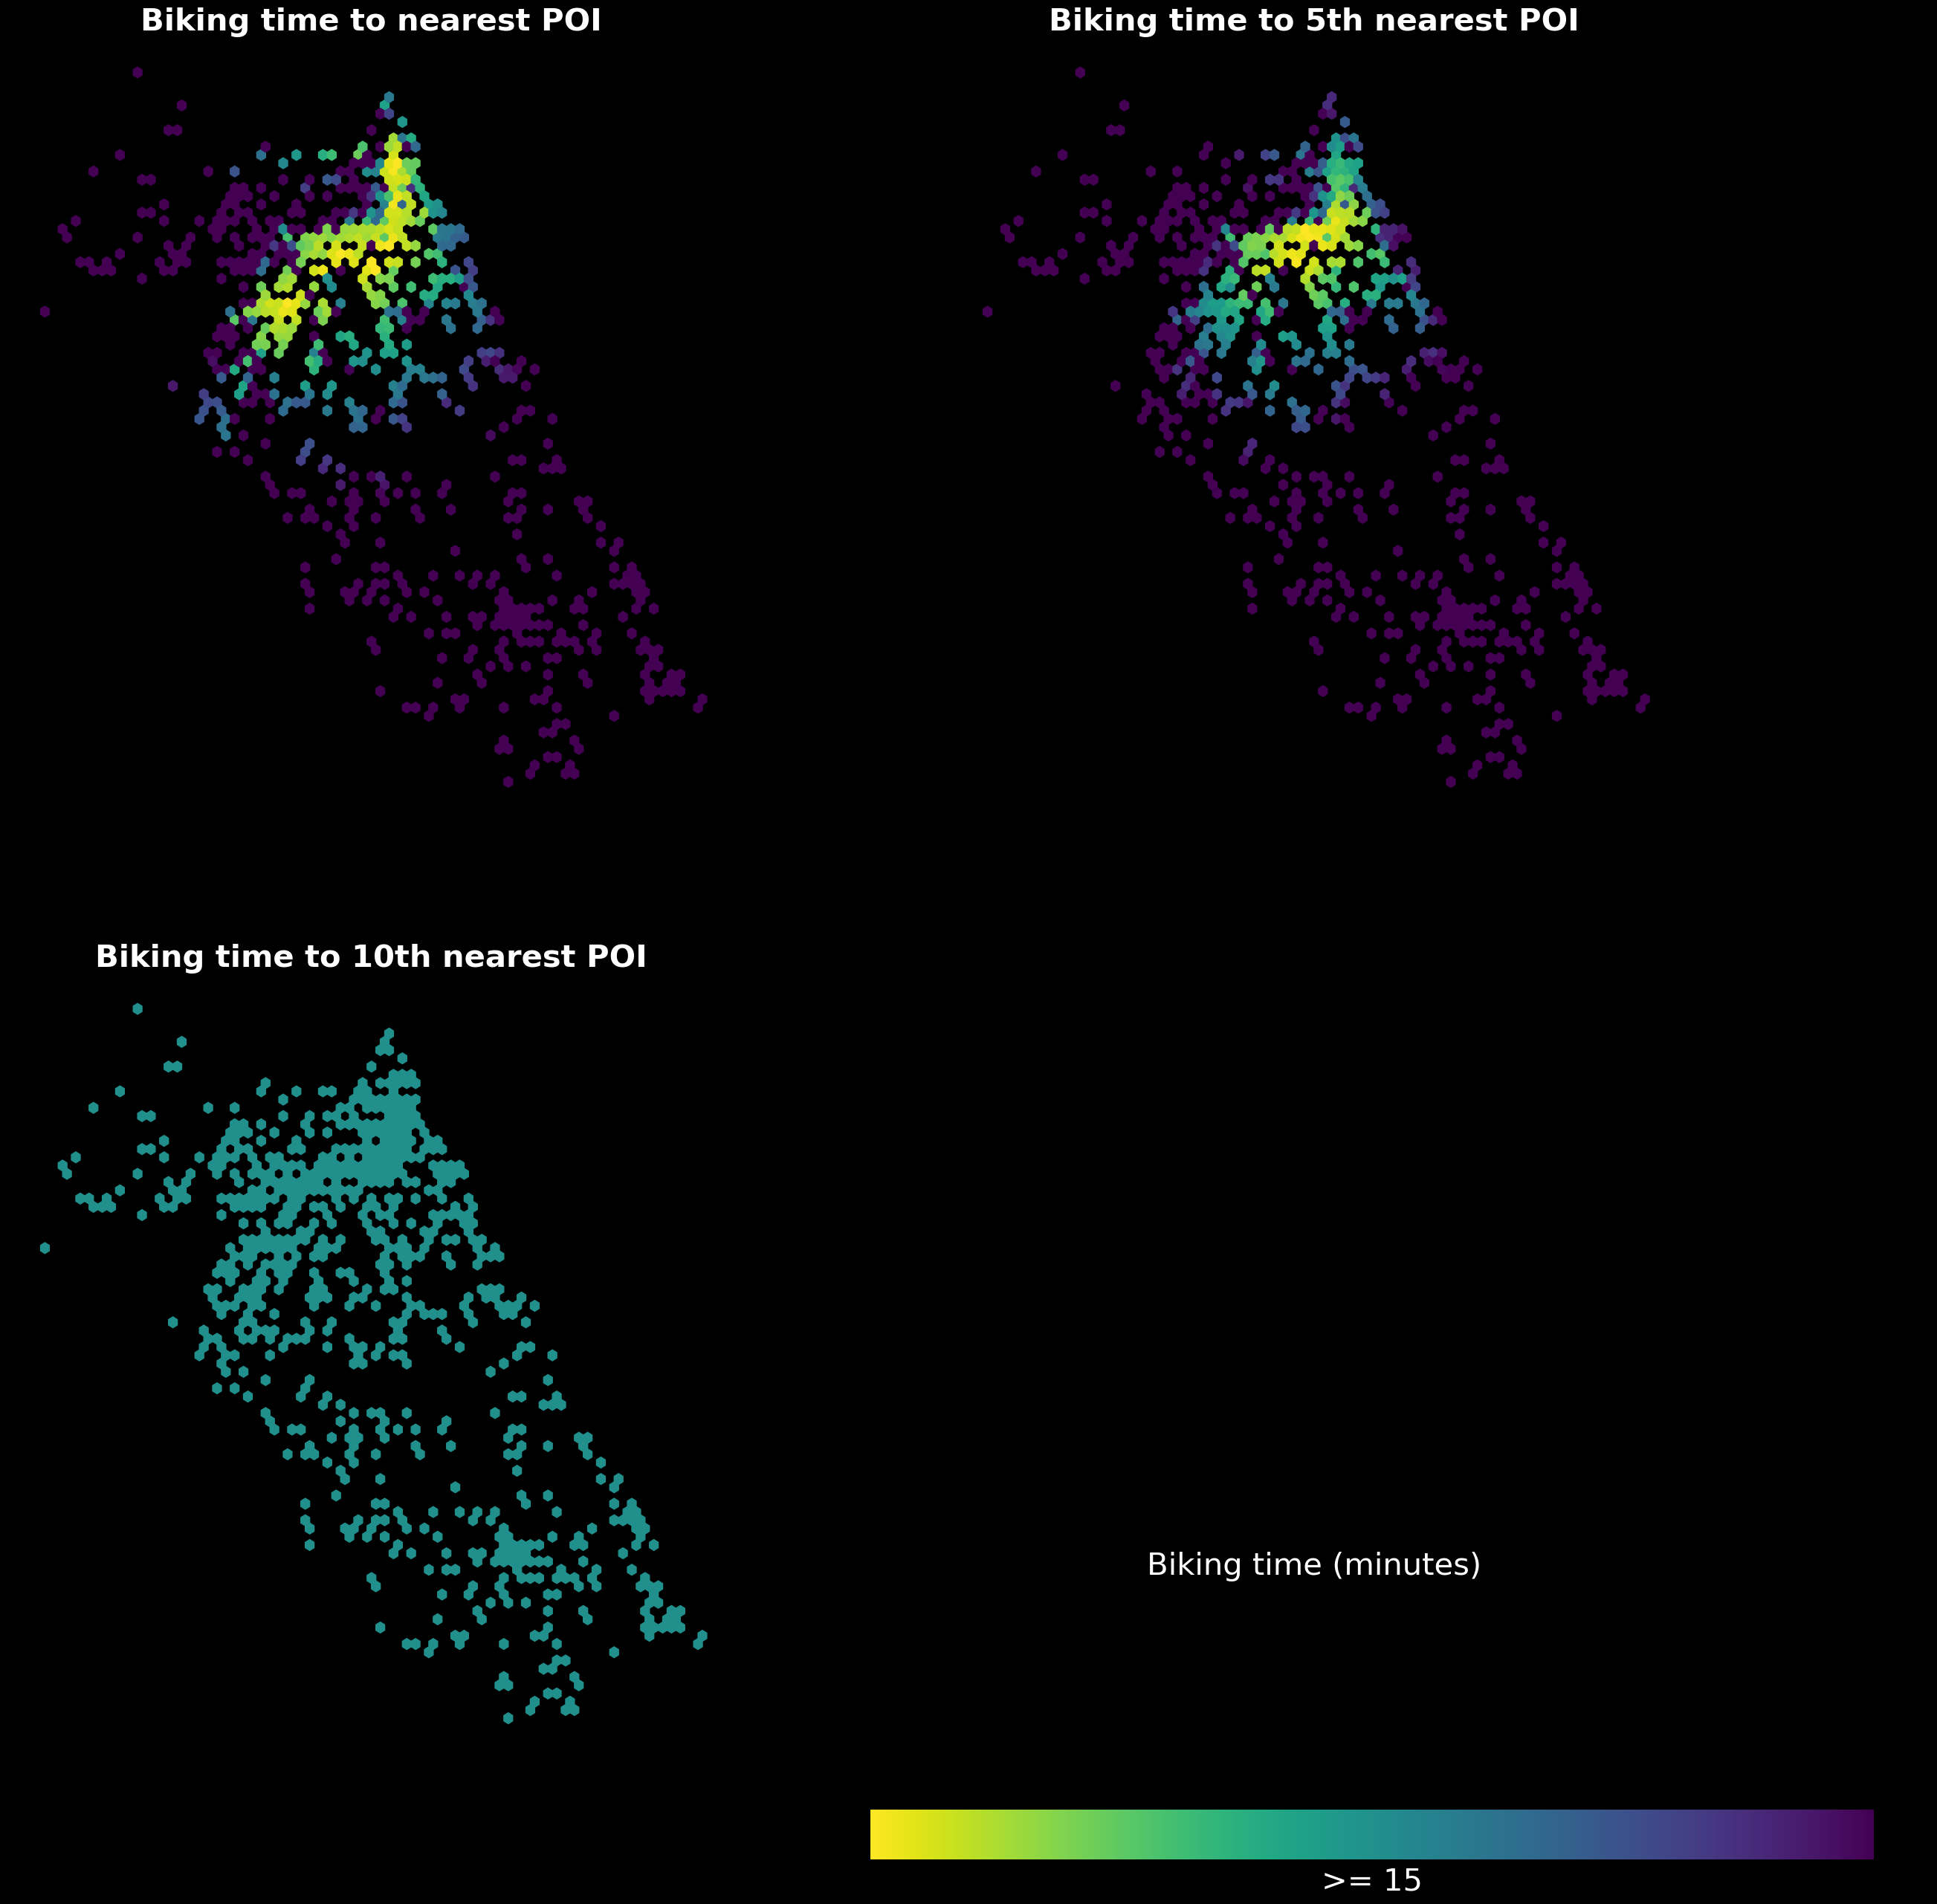

In [31]:
'''
The first part of the analysis relied on the assumption that a dense urban fabric indicates a bikeable place. 
While the physical structure of the street network definitely plays a part,  there's much more to urban space than 
intersection counts.  So, to get a different insight into urban bikeability, I took a slightly more qualitative approach.
Novack et al. (2018) discuss in their article how different urban features affect the pleasantness of urban space. 
This article was helpful as the study was done using OSM data, and the authors even provide lists of different 
features that make urban space pleasant. For my analysis I used their list of OSM features that indicate sociable places, 
or so called "third places" (no work or home). Specifically, using OSM tags, I sourced points of interests, then using Pandana 
I establish a navigable network, positioning the POIs on the unsimplified graph to ensure accurate time computations. Then, with
Pandana I execute a routing analysis to compute a travel time from each network node to its 5 nearest POIs, based on ana average 
walking speed of 15 km/h. Travel times were restricted to POIs within 15 minute biking radius. 
'''

## Network Analysis - Routing Analysis

'''
The initial visualization appeared crowded. To improve clarity, I employed Matplotlib's hexbins to display average travel times 
for each hexagon. It's crucial to mention that depicting travel times to the closest POI may not provide a comprehensive representation.
For instance, an area with one cafe and another with several amenities would appear similarly on the map. Displaying times to the 3th or the 6th 
can offer a more differentiated view. A subsequent comparison showcased variations in visualizations based on 
biking times to different target POIs. This enhanced visualization distinctly identifies areas accessible by bike, showing some 
correlation with intersection density but also highlighting the "bikeability" variations based on the approach used.
'''
def setup_plot_style():
    """Set up plot style."""
    COLOR = 'white'
    plt.rcParams['text.color'] = COLOR
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR

def plot_nearest_poi(nodes, distances, save_path=None):
    """Plot distance to the nearest POI."""
    setup_plot_style()
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.set_axis_off()
    ax.set_aspect('equal')
    fig.set_facecolor((0, 0, 0))
    sc = ax.scatter(
        x=nodes['x'],
        y=nodes['y'], 
        c=distances[1],
        s=1,
        cmap='viridis_r'
    )
    cb = fig.colorbar(sc, ax=ax, shrink=0.8, ticks=[0, 300, 600, 900])
    cb.ax.tick_params(color='none', labelsize=20)
    cb.ax.set_yticklabels(['0', '5', '10', '>= 15'])
    cb.set_label('Biking time to nearest POI (minutes)', fontsize=20, fontweight='bold')

    if save_path:
        plt.savefig(os.path.join(save_path, "nearest_poi_plot.png"))

def plot_hexbin_maps(nodes, distances, save_path=None):
    """Plot hexbin maps for different nearest POIs."""
    setup_plot_style()
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30, 30), constrained_layout=False)
    for axis in ax.flatten():
        axis.set_axis_off()
        axis.set_aspect('equal')
    fig.set_facecolor('black')
    cmap = 'viridis_r'

    # Plots
    axes_indices = [(0, 0), (0, 1), (1, 0)]
    titles = ['Biking time to nearest POI', 'Biking time to 5th nearest POI', 'Biking time to 10th nearest POI']
    pois_indices = [1, 5, 10]  # specify the pois indices here
    for i, (x, y) in enumerate(axes_indices):
        hb = ax[x][y].hexbin(
            x=nodes['x'],
            y=nodes['y'],
            gridsize=75,
            cmap=cmap,
            C=distances[pois_indices[i]],
            alpha=1
        )
        ax[x][y].set_title(titles[i], fontsize=30, fontweight='bold')

    # Colorbar setup
    cbar_ax = fig.add_axes([0.5, 0.01, 0.5, 0.5])
    cbar_ax.set_axis_off()
    cb = plt.colorbar(
        hb,
        ax=cbar_ax,
        shrink=0.9,
        ticks=[82, 300, 600, 900],
        orientation='horizontal',
        aspect=20
    )
    cb.outline.set_edgecolor('none')
    cb.ax.tick_params(color='none', labelsize=30)
    cb.ax.set_xticklabels(['<= 1', '5', '10', '>= 15'])
    ax[1][1].text(0.5, 0.23, 'Biking time (minutes)', fontsize=30, ha='center')
    
    if save_path:
        plt.savefig(os.path.join(save_path, "hexbin_maps.png"))


tags = {
    'amenity': [
        'cafe', 'bar', 'pub', 'restaurant', 'hotel'
    ],
    'shop': [
        'bakery', 'convenience', 'supermarket', 'commercial', 
        'mall', 'department_store', 'clothes', 'fashion', 
        'shoes', 'retail', 'warehouse'
    ],
    'leisure': [
        'fitness_centre', 'sports_centre'
    ]
}

# Get amentities from place
pois = ox.features.features_from_place("Montereale Valcellina, Italy", tags=tags)
    
# Project pois
pois = pois.to_crs(epsg=32632) # Max time to bike in minutes (no routing to nodes further than this)
bike_time = 15

# Biking speed
bike_speed = 15

# Set a uniform biking speed on every edge
for u, v, data in G_lts.edges(data=True):
    data['speed_kph'] = bike_speed
G_lts = ox.add_edge_travel_times(G_lts)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(G_lts, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(G_lts, nodes=False).reset_index()[['u', 'v', 'travel_time']] 
network = pdna.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the pois' geometries
centroids = pois.centroid # Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = bike_time * 60

# Set the pois' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x, 
    y_col=centroids.y
) # calculate travel time to 10 nearest pois from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

plot_nearest_poi(nodes, distances, save_path=city_folder_path)
plot_hexbin_maps(nodes, distances, save_path=city_folder_path)
